## Problem Statement:
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing the sales of their products.

The dataset includes two files:

- bigdatamart_Train.csv: Use this file for the model building purpose. 

- bigdatamart_Test.csv: Use this file for getting predictions from the trained model. 

In [254]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore


from sklearn.linear_model import LinearRegression,Lasso,LassoCV,Ridge,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

In [255]:
data_train=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Train.csv")

data_train.sample(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
2722,FDY57,20.200,Regular,0.121500,Snack Foods,95.0752,OUT045,2002,NaN,Tier 2,Supermarket Type1,2588.6304
7991,FDC60,5.425,Regular,0.114472,Baking Goods,88.3514,OUT046,1997,Small,Tier 1,Supermarket Type1,2833.6448
2694,FDS26,20.350,Low Fat,0.089608,Dairy,262.1594,OUT049,1999,Medium,Tier 1,Supermarket Type1,3139.9128
6547,FDY38,NaN,Regular,0.208663,Dairy,231.8300,OUT019,1985,Small,Tier 1,Grocery Store,466.0600


Here are some random 4 records of training dataset.

In [256]:
data_test=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/bigdatamart_rep/master/bigdatamart_Test.csv")

data_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


Here are 5 records of test data shown from the start.

In [257]:
data_test.shape

(5681, 11)

The test data has 5681 no. of records and 11 no. of columns. In this all columns are features no target value. so this dataset will be used for test purpose.

In [258]:
data_train.shape

(8523, 12)

The training data has 8523no. of records and 12 no. of columns contains target too.

In [259]:
data_train.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

From here we know that there are 1463 rows in Item_weight column are null & 2410 no. rows are null in Outlet_Size.

In [260]:
data_test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

From here we know that there are 976 rows in Item_weight column are null & 1606 no. rows are null in Outlet_Size.

In [261]:
data_train.columns.tolist()

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

Item_Identifier:
Unique product ID

Item_Weight:
Weight of product

Item_Fat_Content:
Whether the product is low fat or not

Item_Visibility:
The % of total display area of all products in a store allocated to the particular product

Item_Type:
The category to which the product belongs

Item_MRP:
Maximum Retail Price (list price) of the product

Outlet_Identifier:
Unique store ID

Outlet_Establishment_Year:
The year in which store was established

Outlet_Size:
The size of the store in terms of ground area covered

Outlet_Location_Type:
The type of city in which the store is located

Outlet_Type:
Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales:
Sales of the product in the particular store. This is the outcome variable to be predicted.

In [262]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
Item_Identifier              5681 non-null object
Item_Weight                  4705 non-null float64
Item_Fat_Content             5681 non-null object
Item_Visibility              5681 non-null float64
Item_Type                    5681 non-null object
Item_MRP                     5681 non-null float64
Outlet_Identifier            5681 non-null object
Outlet_Establishment_Year    5681 non-null int64
Outlet_Size                  4075 non-null object
Outlet_Location_Type         5681 non-null object
Outlet_Type                  5681 non-null object
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB



There are two columns that has null values. that columns are Item_Weight that has 4705 non-null values & Outlet_Size that has 4075 non-null values.

In [263]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


There are two columns that has null values. that columns are Item_Weight that has 7060 non-null values & Outlet_Size that has 6113 non-null values.

#### removing null values.

In [264]:
Unique_ids=data_train.Item_Identifier.unique().tolist()
data_id={}
for i in Unique_ids:
    j=data_train.loc[data_train['Item_Identifier']==i].mean()
    data_id[i]=j['Item_Weight']
data_id


{'FDA15': 9.299999999999999,
 'DRC01': 5.92,
 'FDN15': 17.5,
 'FDX07': 19.2,
 'NCD19': 8.93,
 'FDP36': 10.395,
 'FDO10': 13.65,
 'FDP10': 19.0,
 'FDH17': 16.2,
 'FDU28': 19.2,
 'FDY07': 11.799999999999999,
 'FDA03': 18.5,
 'FDX32': 15.1,
 'FDS46': 17.6,
 'FDF32': 16.35,
 'FDP49': 9.0,
 'NCB42': 11.8,
 'DRI11': 8.26,
 'FDU02': 13.35,
 'FDN22': 18.85,
 'FDW12': 8.315,
 'NCB30': 14.6,
 'FDC37': 15.5,
 'FDR28': 13.85,
 'NCD06': 13.0,
 'FDV10': 7.645,
 'DRJ59': 11.65,
 'FDE51': 5.925,
 'FDC14': 14.5,
 'FDV38': 19.25,
 'NCS17': 18.6,
 'FDP33': 18.7,
 'FDO23': 17.85,
 'DRH01': 17.5,
 'NCX29': 10.0,
 'FDV20': 20.2,
 'DRZ11': 8.85,
 'FDX10': 6.385000000000001,
 'FDB34': 15.25,
 'FDK43': 9.8,
 'FDA46': 13.6,
 'FDC02': 21.35,
 'FDL50': 12.15,
 'FDM39': 6.42,
 'NCP05': 19.599999999999998,
 'FDV49': 10.0,
 'FDL12': 15.85,
 'FDS02': 10.195,
 'NCL17': 7.39,
 'FDM40': 10.195,
 'FDR13': 9.895,
 'FDA43': 10.895,
 'NCP18': 12.15,
 'FDK21': 7.905,
 'NCX54': 9.195,
 'DRK35': 8.365,
 'FDY21': 15.1,
 'FDI26'

Here we created a dictionary in that the unique id of the product contains the average weight of the item.

In [265]:
def fill_weight_by_id(data):
    
    weight,idd=data[0],data[1]
    if (pd.isnull(weight)): 
        return data_id[idd]
        
    else:
        return weight


created a function to fill null value with the average weight to that correspondant id.

In [266]:
data_train['Item_Weight']=data_train[['Item_Weight','Item_Identifier']].apply(fill_weight_by_id,axis=1)

Applying fill_weight_by_id function to "Item_Weight" column so that it fill null values with the average weiht with corresponding ids.

In [267]:
print('NO of null values in the item_weight column of data_test dataset::',data_train.Item_Weight.isna().sum())

NO of null values in the item_weight column of data_test dataset:: 4


Still there are 4 null values

In [268]:
np.where(data_train.Item_Weight.isnull())

(array([ 927, 1922, 4187, 5022], dtype=int64),)

These are the indices where the item_weight column has null values.

In [269]:
np.where(data_train.Item_Identifier=='FDN52')

(array([927], dtype=int64),)

Here we analyse that the values are still null because the product has no other specific value for weight in it.

In [270]:
Unique_item_type=data_train.Item_Type.unique().tolist()
data_type={}
for i in Unique_item_type:
    j=data_train.loc[data_train['Item_Type']==i].mean()
    data_type[i]=j['Item_Weight']
data_type

{'Dairy': 13.37990455212926,
 'Soft Drinks': 11.879775280898892,
 'Meat': 12.771211764705916,
 'Fruits and Vegetables': 13.236712662337732,
 'Household': 13.524780219780286,
 'Baking Goods': 12.28531684698612,
 'Snack Foods': 13.031230191826587,
 'Frozen Foods': 12.782403508771965,
 'Breakfast': 12.779727272727262,
 'Health and Hygiene': 13.052326923076956,
 'Hard Drinks': 11.456238317757009,
 'Canned': 12.403320493066275,
 'Breads': 11.297689243027898,
 'Starchy Foods': 13.841385135135132,
 'Others': 13.97943786982248,
 'Seafood': 12.521953125000001}

Here we created a dictionary in that the unique type of the item contains the average weight of the item.

In [271]:
def fill_weight_by_itemType(data):
    
    weight,typ=data[0],data[1]
    if (pd.isnull(weight)): 
        return data_type[typ]
        
    else:
        return weight

created a function to fill null value with the average weight to that correspondant id.

In [272]:
data_train['Item_Weight']=data_train[['Item_Weight','Item_Type']].apply(fill_weight_by_itemType,axis=1)

data_train.Item_Weight.isna().sum()

0

Applying fill_weight_by_itemType function to "Item_Weight" column so that it fill null values with the average weiht with corresponding types of item.

Now in data_train dataset there are null vales in the Item_weight Column.

Now doing same logic to the data_test dataset for removing null values in the "Item_Wight" column.

In [273]:
Unique_ids=data_test.Item_Identifier.unique().tolist()
data_id={}
for i in Unique_ids:
    j=data_test.loc[data_test['Item_Identifier']==i].mean()
    data_id[i]=j['Item_Weight']

def fill_weight_by_id(data):
    
    weight,idd=data[0],data[1]
    if (pd.isnull(weight)): 
        return data_id[idd]
        
    else:
        return weight
    
data_test['Item_Weight']=data_test[['Item_Weight','Item_Identifier']].apply(fill_weight_by_id,axis=1)

print('NO. of null values in the item_weight column of data_test dataset used only fill_weight_by_id function::',data_test.Item_Weight.isna().sum())


Unique_item_type=data_test.Item_Type.unique().tolist()
data_type={}
for i in Unique_item_type:
    j=data_test.loc[data_train['Item_Type']==i].mean()
    data_type[i]=j['Item_Weight']


def fill_weight_by_itemType(data):
    
    weight,typ=data[0],data[1]
    if (pd.isnull(weight)): 
        return data_type[typ]
        
    else:
        return weight

data_test['Item_Weight']=data_test[['Item_Weight','Item_Type']].apply(fill_weight_by_itemType,axis=1)



print('NO. of null values in the item_weight column of data_test now used  dataset fill_weight_by_itemType function too..::',data_test.Item_Weight.isna().sum())


NO. of null values in the item_weight column of data_test dataset used only fill_weight_by_id function:: 20
NO. of null values in the item_weight column of data_test now used  dataset fill_weight_by_itemType function too..:: 0


In [274]:

data_train.isna().sum()



Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [275]:
data_test.isna().sum()


Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [276]:
data_train.Outlet_Size.unique()


array(['Medium', nan, 'High', 'Small'], dtype=object)

In [277]:
data_train.Outlet_Size=data_train.Outlet_Size.fillna(data_train.Outlet_Size.mode()[0])

AS the test data also has the same features columns . in the dataset. So, i think there is no need to describe them.

Here also we remove null values of Outlet_size of test dataset by the mode.

In [278]:
data_train.Outlet_Size.unique()

array(['Medium', 'High', 'Small'], dtype=object)

Here we remove null values of Outlet_size of training dataset by the mode.

In [279]:
data_test.Outlet_Size=data_test.Outlet_Size.fillna(data_test.Outlet_Size.mode()[0])

data_test.Outlet_Size.unique()

array(['Medium', 'Small', 'High'], dtype=object)

In [280]:
data_test.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [281]:
data_train.Outlet_Size.unique()

array(['Medium', 'High', 'Small'], dtype=object)

In [282]:
data_train.Outlet_Size=data_train.Outlet_Size.fillna(data_train.Outlet_Size.mode()[0])

data_train.Outlet_Size.unique()

array(['Medium', 'High', 'Small'], dtype=object)

Here we remove null values of Outlet_size of training dataset by the mode. Doing same with the data_test dataset

In [283]:
data_test.Outlet_Size=data_test.Outlet_Size.fillna(data_test.Outlet_Size.mode()[0])

data_test.Outlet_Size.unique()

array(['Medium', 'Small', 'High'], dtype=object)

<Figure size 1440x4320 with 0 Axes>

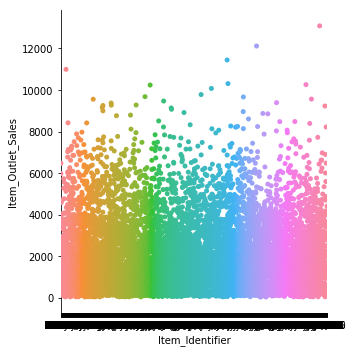

In [284]:
plt.figure(figsize=(20,60))
sns.catplot(x='Item_Identifier', y='Item_Outlet_Sales',data=data_train)
plt.show()

Here the Item_identifier are distributed within range of 0 to 6500, mostly.

<Figure size 1440x4320 with 0 Axes>

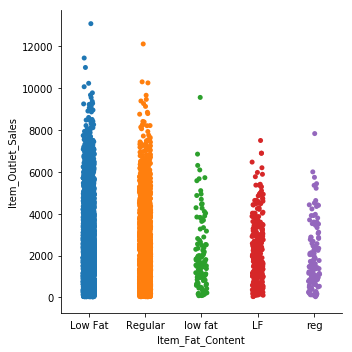

In [285]:
plt.figure(figsize=(20,60))
sns.catplot(x='Item_Fat_Content', y='Item_Outlet_Sales',data=data_train)
plt.show()

here we can see that the low fat,Low Fat & Lf these are one categorical value while Regular & reg are another categorical value.

<Figure size 4320x0.144 with 0 Axes>

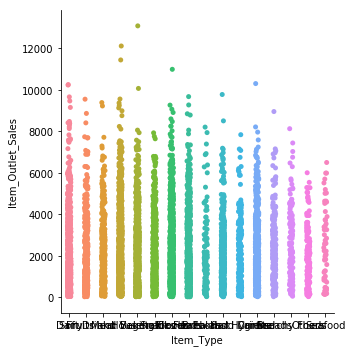

In [286]:
plt.figure(figsize=(60,0.002),clear=True)
sns.catplot(x='Item_Type', y='Item_Outlet_Sales',data=data_train,)
plt.tight_layout()

All item type are continous with the sale.

<Figure size 1440x4320 with 0 Axes>

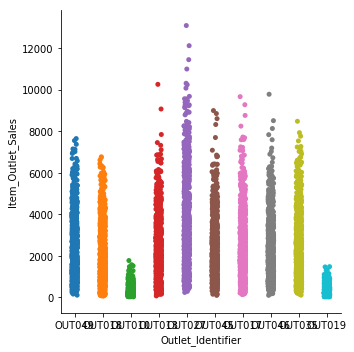

In [287]:
plt.figure(figsize=(20,60))
sns.catplot(x='Outlet_Identifier', y='Item_Outlet_Sales',data=data_train)
plt.show()

In [288]:
data_train.Outlet_Identifier.unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In Outlet_identifier OUT010 and OUT019 there is min sales someow.

<Figure size 1440x4320 with 0 Axes>

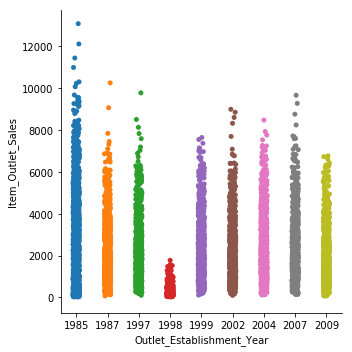

In [289]:
plt.figure(figsize=(20,60))
sns.catplot(x='Outlet_Establishment_Year', y='Item_Outlet_Sales',data=data_train)
plt.show()

Here we can see no. of outlet increse there is some decrease in sales. But the older one got the max sales.

<Figure size 1440x4320 with 0 Axes>

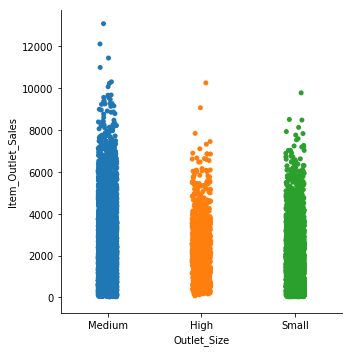

In [290]:
plt.figure(figsize=(20,60))
sns.catplot(x='Outlet_Size', y='Item_Outlet_Sales',data=data_train)
plt.show()

In medium Outlet_size there is max sale as well not in the high or small type of outlet.

<Figure size 1440x4320 with 0 Axes>

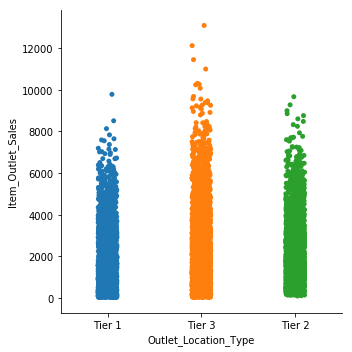

In [291]:
plt.figure(figsize=(20,60))
sns.catplot(x='Outlet_Location_Type', y='Item_Outlet_Sales',data=data_train)
plt.show()

Here we can there is somehow max sales sales in tier 3.

<Figure size 1440x4320 with 0 Axes>

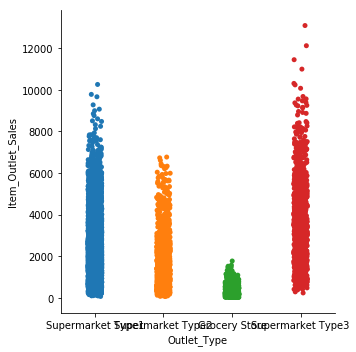

In [292]:
plt.figure(figsize=(20,60))
sns.catplot(x='Outlet_Type', y='Item_Outlet_Sales',data=data_train)
plt.show()

In [293]:
data_train.Outlet_Type.unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

Here we cann see that in Grocery Store the sale is not good.

In [294]:
cat_dtype=['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Location_Type','Outlet_Type']

In [295]:
cat_dtype

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [296]:
data_train['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

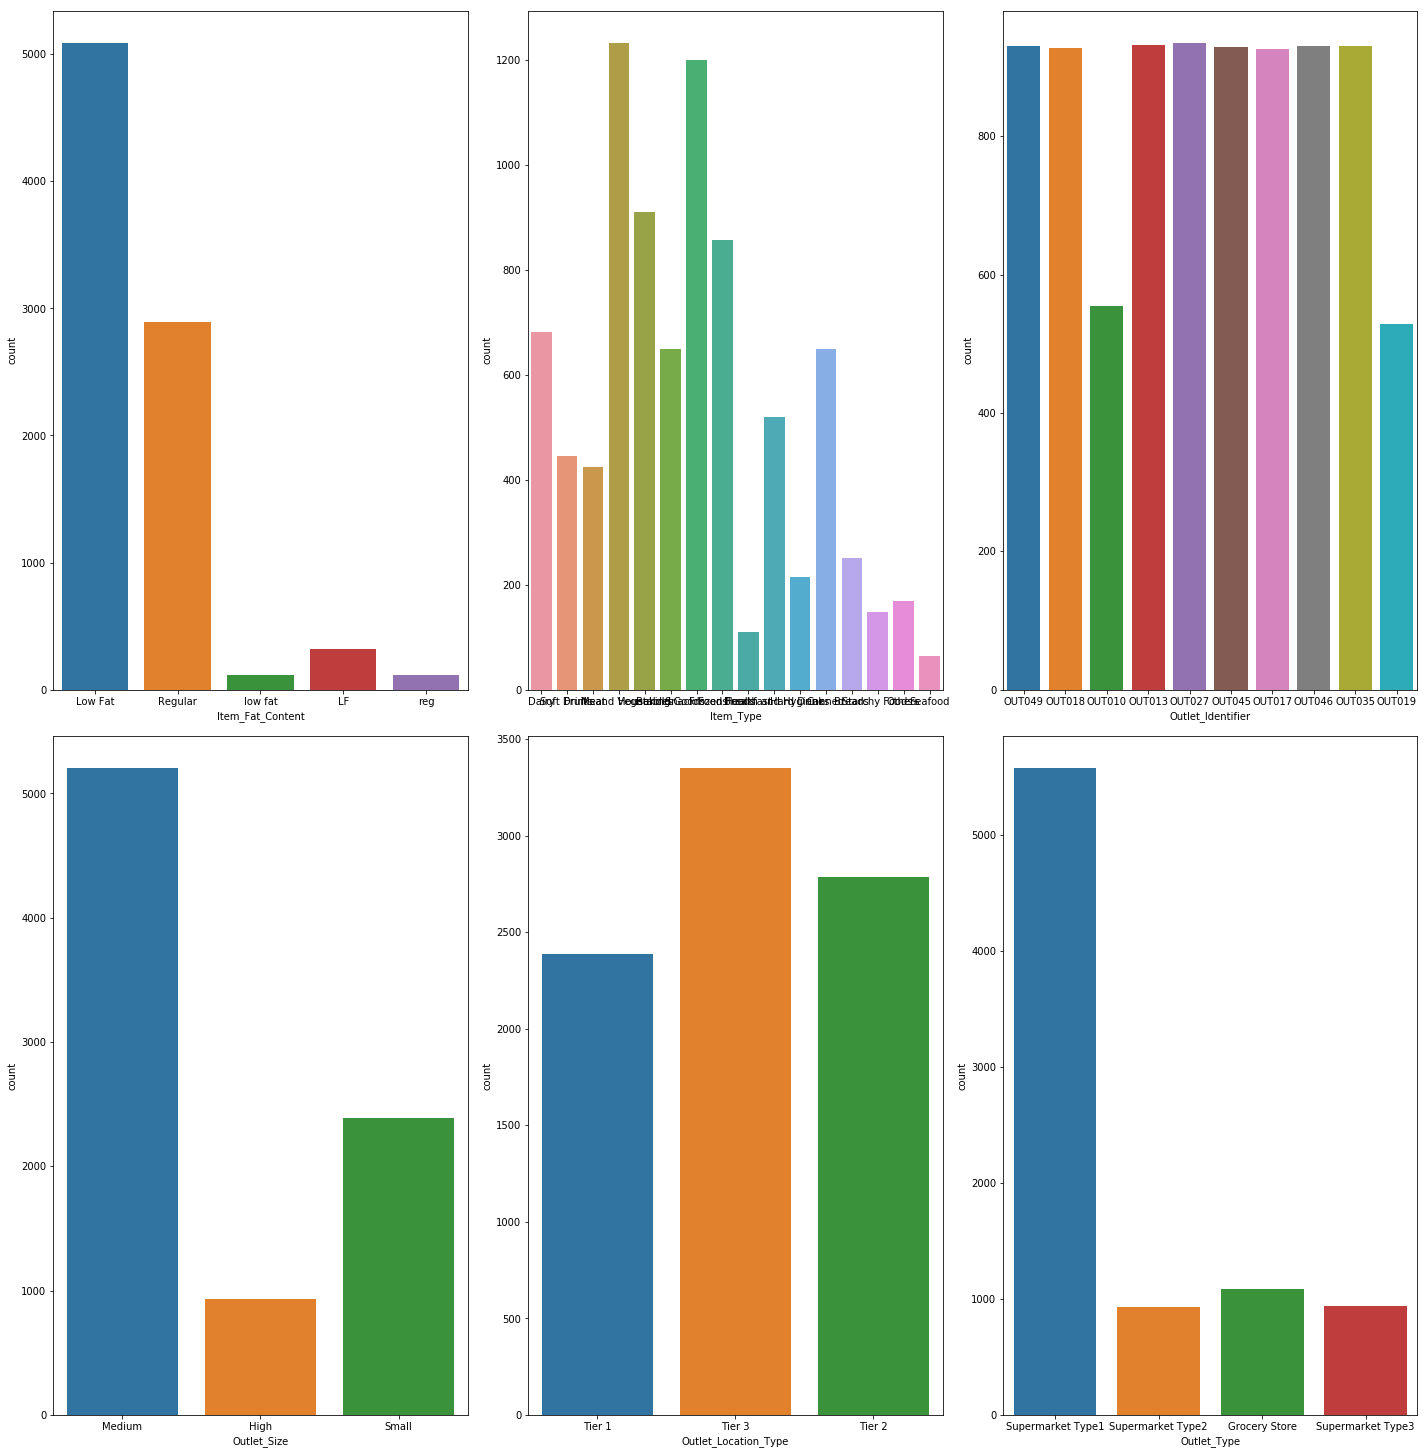

In [297]:
plt.figure(figsize=(20,40))
graph=1
for col in cat_dtype:
    if graph<11:
        ax=plt.subplot(4,3,graph)
        sns.countplot(data_train[col])
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

Graph 1:
    Its tells that  the item contains Low fat product more. This column needed to be transform.
    
Graph2:
    'Meat' ,'Baking Goods' has highest sales of these products. and  has lowest sale for Breakfast products.
    
Graph3:
    this graphs is showing no. of outlet that has their unique ids
    
Graph4:
    There are less no. of high Outlet_size 
    
Graph5:
    Showing no. of Outlet_location_type
    
Graph6:
    There are "Super market type 1" outlier are more in markets while others.
    

##### We have to use encoder techniques to analyse more data.Also for checking Outliers,distribution of Data. to both the Traing & Test Data.

In [298]:
data_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [299]:
le=LabelEncoder()
data_train.Item_Identifier=le.fit_transform(data_train.Item_Identifier)

data_train.Item_Fat_Content=data_train.Item_Fat_Content.replace({'Low Fat':0,"LF":0,'low fat':0,"reg":1,"Regular":1})

data_train.Item_Type=le.fit_transform(data_train.Item_Type)

data_train.Outlet_Identifier=le.fit_transform(data_train.Outlet_Identifier)

data_train.Outlet_Type=le.fit_transform(data_train.Outlet_Type)

uSED lABEL eNCODER TO TRANSFORM THE CATEGORICAL dATA INTO INTGER DATA TYPE iN tRAIN DATAsET .

In [300]:
data_test.Item_Fat_Content=data_test.Item_Fat_Content.replace({'Low Fat':0,"LF":0,'low fat':0,"reg":1,"Regular":1})

data_test.Item_Identifier=le.fit_transform(data_test.Item_Identifier)

data_test.Item_Type=le.fit_transform(data_test.Item_Type)

data_test.Outlet_Identifier=le.fit_transform(data_test.Outlet_Identifier)

data_test.Outlet_Type=le.fit_transform(data_test.Outlet_Type)

uSED lABEL eNCODER TO TRANSFORM THE CATEGORICAL dATA INTO INTGER DATA TYPE iN tEST DATAsET .

In [301]:
data_train.Outlet_Size.unique()

array(['Medium', 'High', 'Small'], dtype=object)

sHOWING tHE UNIQUE VALUE oF tHE oUTLET_sIZE COLUMN.

In [302]:
data_train.Outlet_Location_Type.unique()

array(['Tier 1', 'Tier 3', 'Tier 2'], dtype=object)

sHOWING tHE UNIQUE VALUE oF tHE oUTLET_lOCATION_tYPE COLUMN.

In [303]:
Oe=OrdinalEncoder(categories=[['Small','Medium','High'],['Tier 1','Tier 2','Tier 3']])

data_train[['Outlet_Size','Outlet_Location_Type']]=Oe.fit_transform(data_train[['Outlet_Size','Outlet_Location_Type']])

data_test[['Outlet_Size','Outlet_Location_Type']]=Oe.fit_transform(data_test[['Outlet_Size','Outlet_Location_Type']])

Used Ordinal Encoder as the the size & location type of outlet is in order. So, we need to transform it in an order.

In [304]:
data_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,1103,20.750,0,0.007565,13,107.8622,9,1999,1.0,0.0,1
1,1067,8.300,1,0.038428,4,87.3198,2,2007,1.0,1.0,1
2,1406,14.600,0,0.099575,11,241.7538,0,1998,1.0,2.0,0
3,809,7.315,0,0.015388,13,155.0340,2,2007,1.0,1.0,1
4,1184,13.600,1,0.118599,4,234.2300,5,1985,1.0,2.0,3


After removing nan, transormed training dataset is represented with top 5 records.

In [305]:
data_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1.0,0.0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1.0,2.0,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1.0,0.0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,1.0,2.0,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,2.0,2.0,1,994.7052


After removing nan, transormed testing dataset is represented with top 5 records.

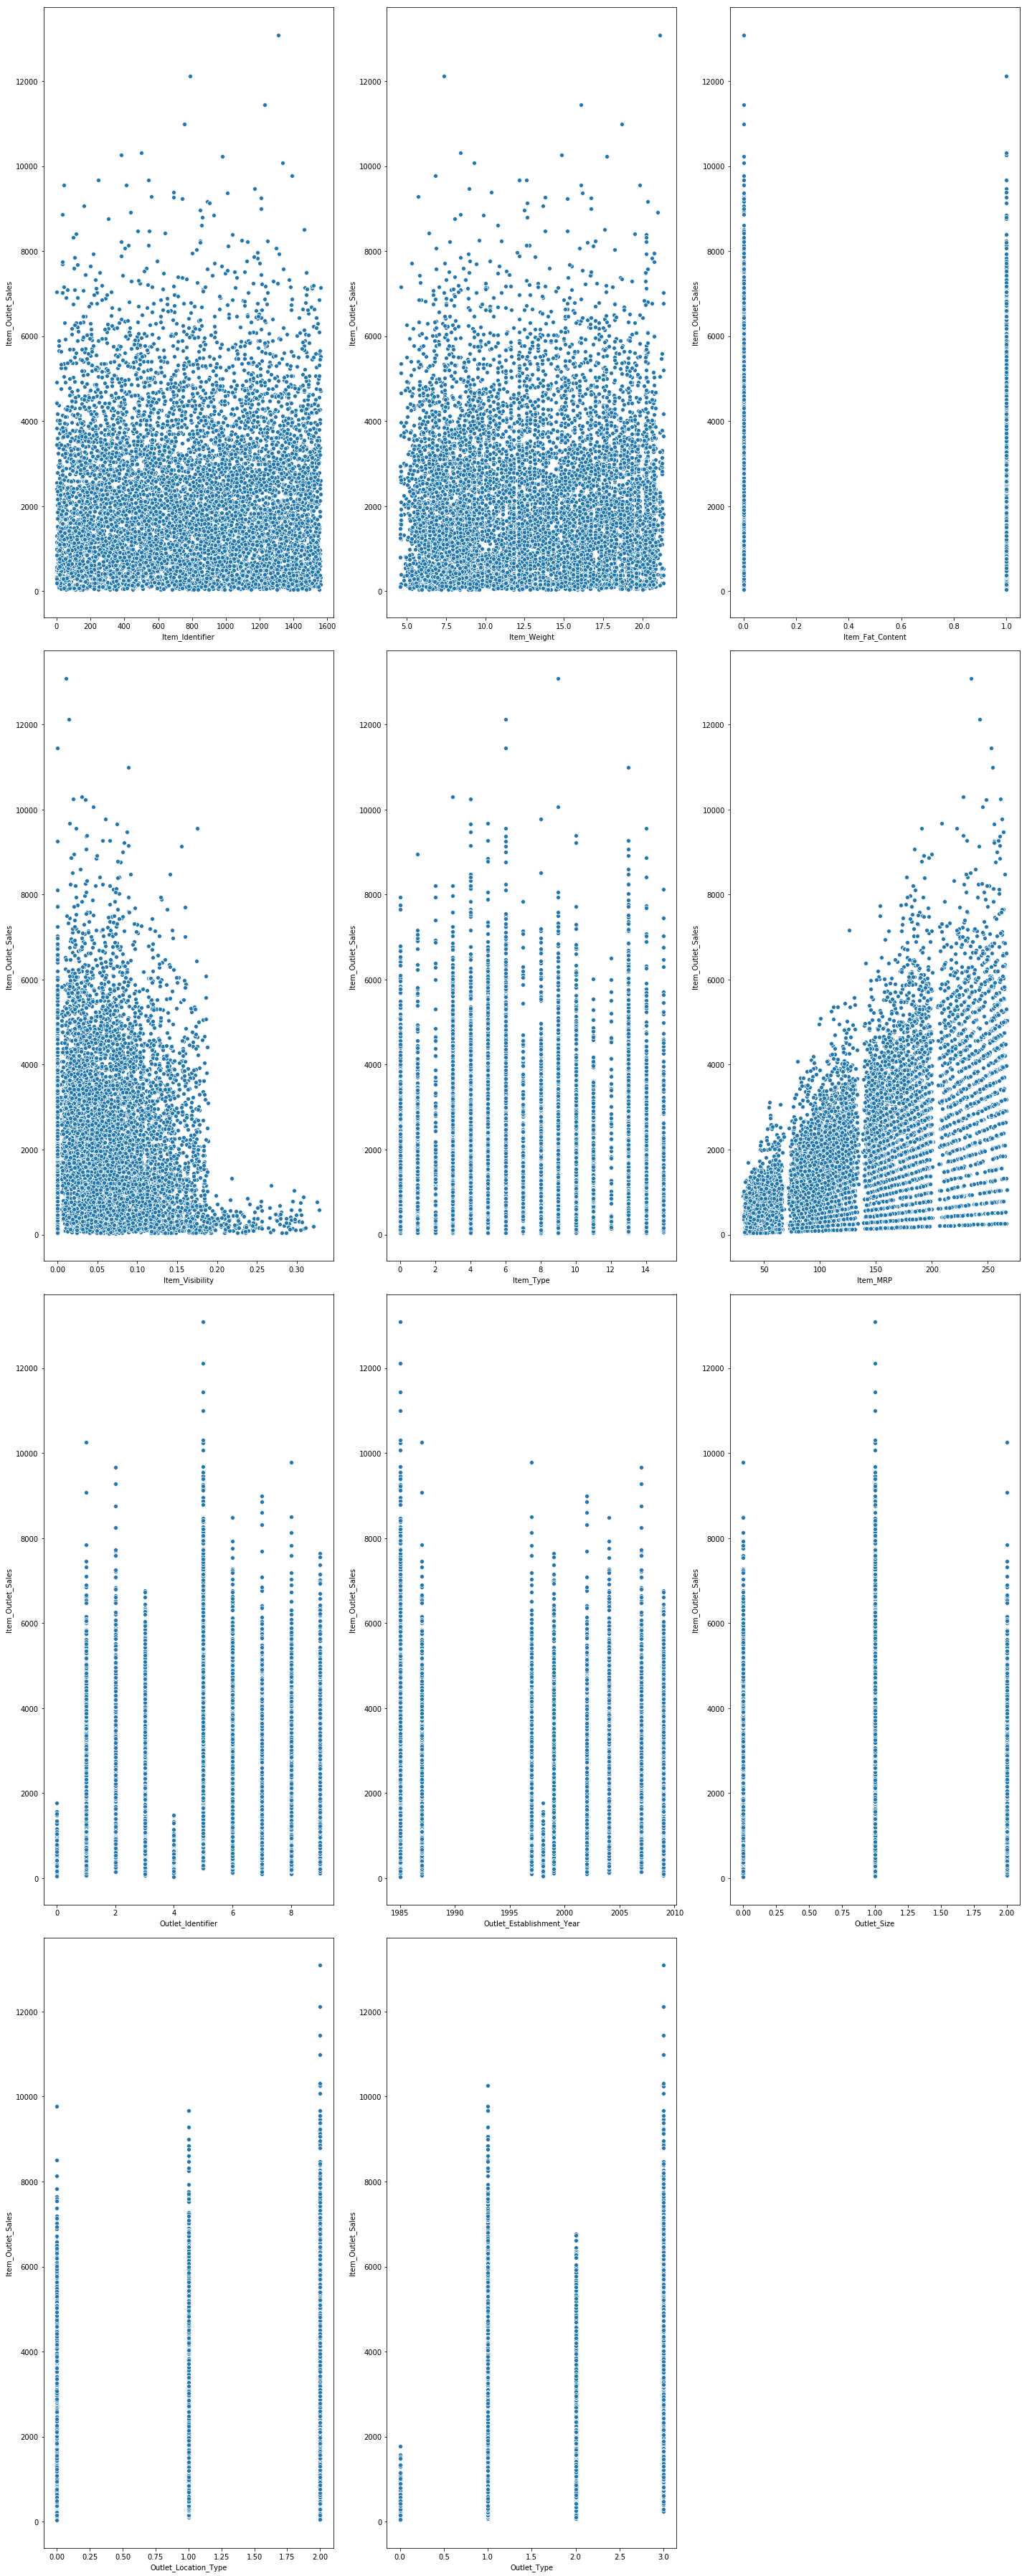

In [306]:
plt.figure(figsize=(20,50))
graph=1
for col in data_train:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.scatterplot(x=data_train[col],y=data_train.Item_Outlet_Sales)
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

Graph1: It seems to be like that the  unique id of item is normally distributed  and contains some outliers.And also seems to be like no relation with Item_Outlet_sales.

Graph2: It seems to be like that the  weight of item is normally distributed  and contains some outliers.And also seems to be like no relation with Item_Outlet_sales. 

Graph3:  It seems to be like that the  fat content  of item is normally distributed  and contains some outliers.And also seems to be like no relation with Item_Outlet_sales.

Graph4: Its seems like leess the visibility more the sales of item.

Graph5: the type of items are equally distributed

Graph6: Higher the Mrp highe the sales o the item.

Graph7: There are some id outlet that has low sales and are continous.

Graph8: As the the outlet are establishing there is somehow very less decrease in the sales. thatmeans the no. outlet increasing there is very less decrease of sale.

Graph9: the medium size outlat sizes are high.

Graph10: lower the location higher the sales.

Graph 11: the outlet_type 0 has minimium sales while other types in it.

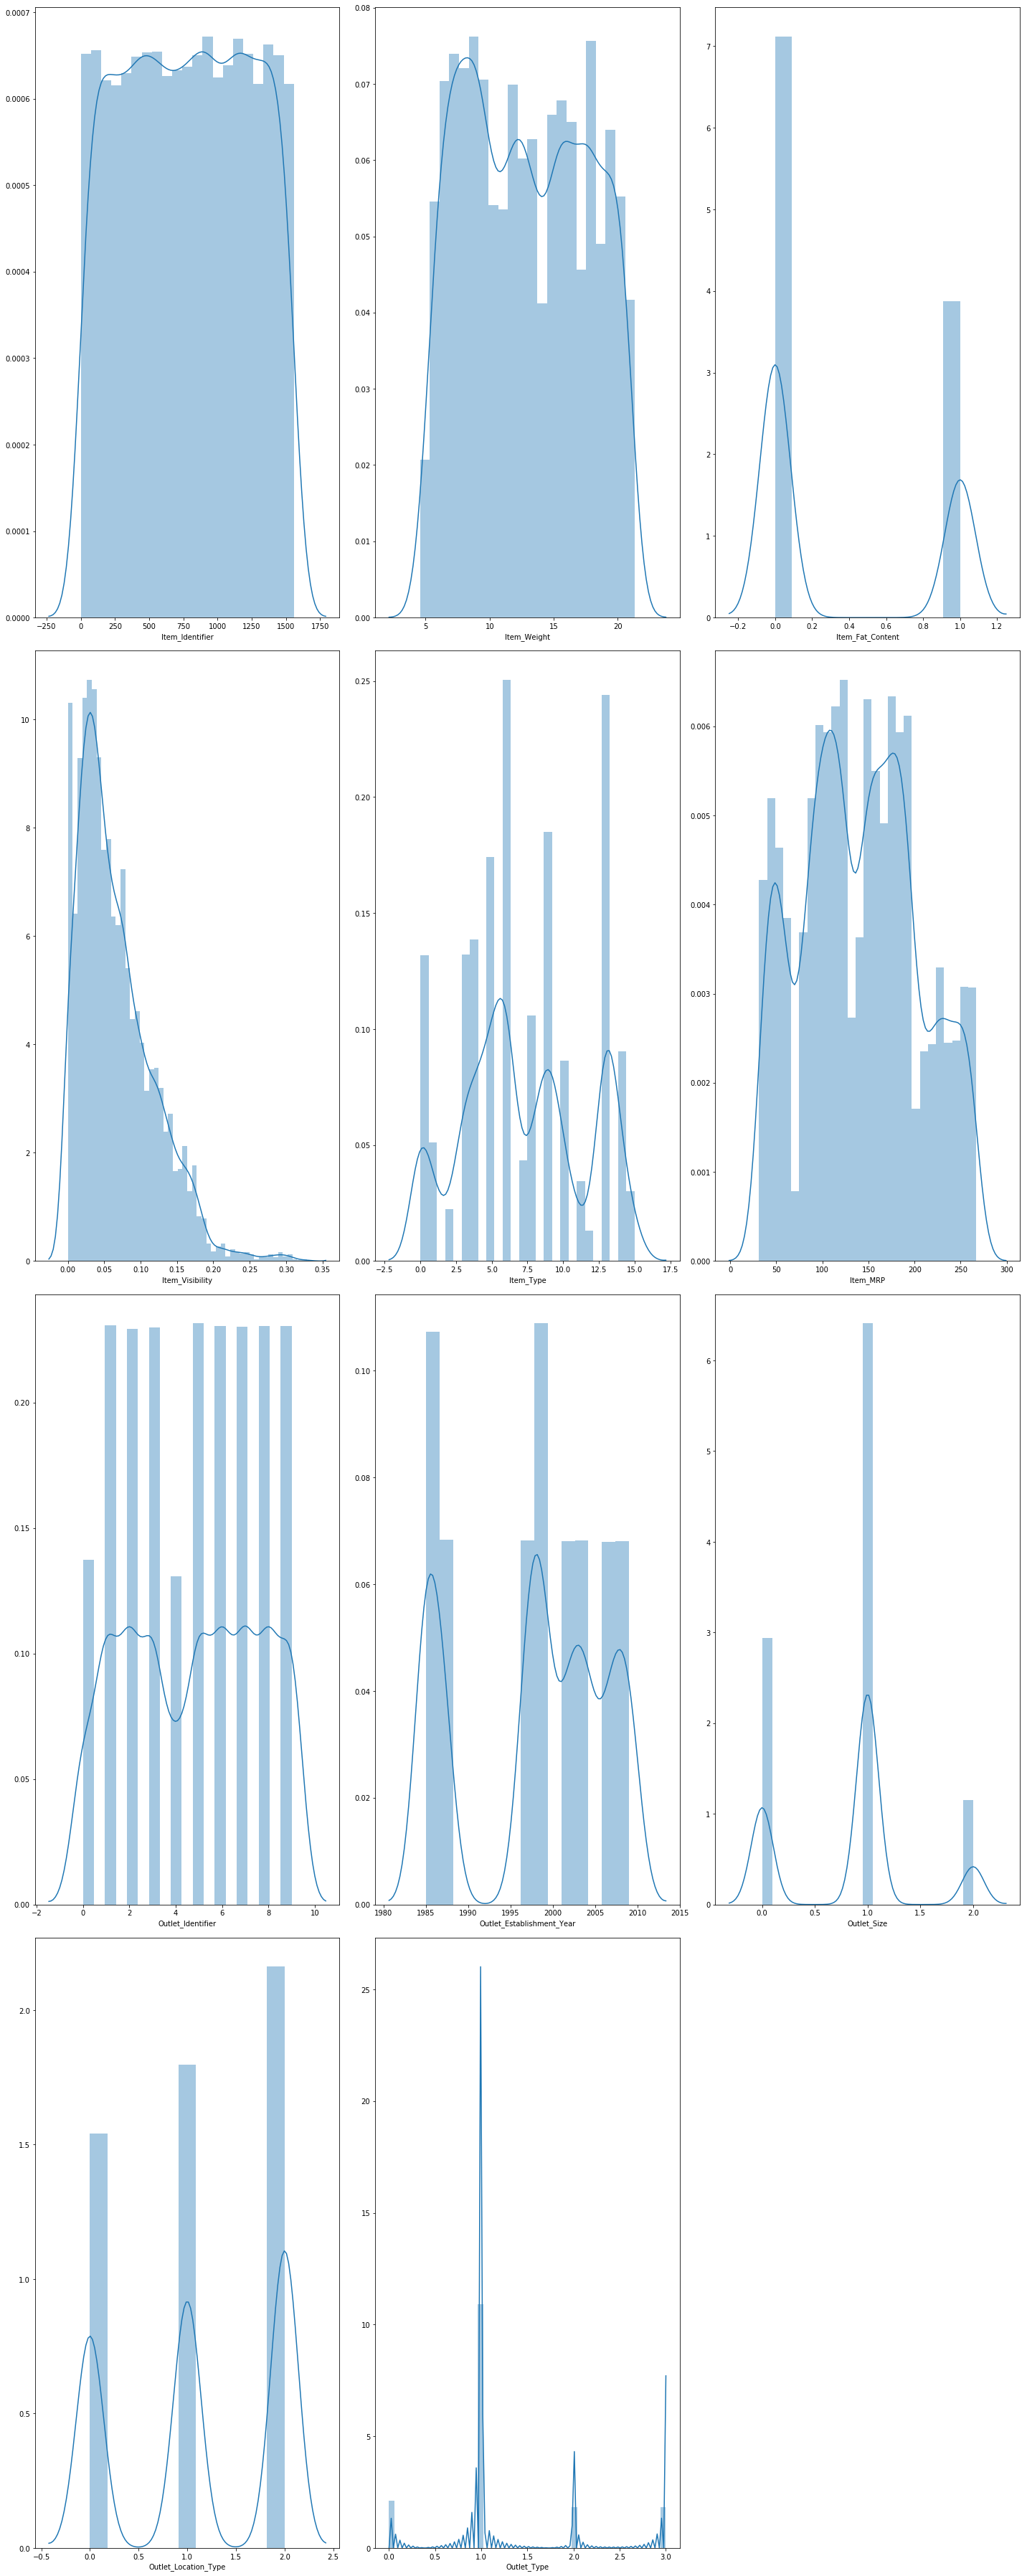

In [307]:
plt.figure(figsize=(20,50))
graph=1
for col in data_train:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.distplot(data_train[col])
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

Graph1: It seems to be like that the  unique id of item is normally distributed .

Graph2: It seems to be like that the  weight of item is normally distributed.

Graph3:  It seems to be like that the  fat content  of item is not normally distributed.

Graph4: Its seems like the visibility skewed.

Graph5: the type of items are equally distributed

Graph6: It seems to be like that the  MRP of item is normally distributed.

Graph7: It seems to be like that the  ids of outlet are normally distributed..

Graph8: It seems to be like that the establishment of outlet is normally distributed.

Graph9: It seems to be like that the  size of outlet is not normally distributed.

Graph10: It seems to be like that the  location type of outlet is not normally distributed.

Graph 11: It seems to be like that the type of outlet is not normally distributed.

In [308]:
data_train.skew()

Item_Identifier             -0.008877
Item_Weight                  0.070333
Item_Fat_Content             0.616705
Item_Visibility              1.167091
Item_Type                    0.101655
Item_MRP                     0.127202
Outlet_Identifier           -0.059861
Outlet_Establishment_Year   -0.396641
Outlet_Size                  0.087072
Outlet_Location_Type        -0.209093
Outlet_Type                  0.927438
Item_Outlet_Sales            1.177531
dtype: float64

'Item_Fat_Content','Item_Visibility'& 'Outlet_Type' are not in range of -0.5 to 0.5. So they are skewed columns. while others are in range so, there distibution is normal.

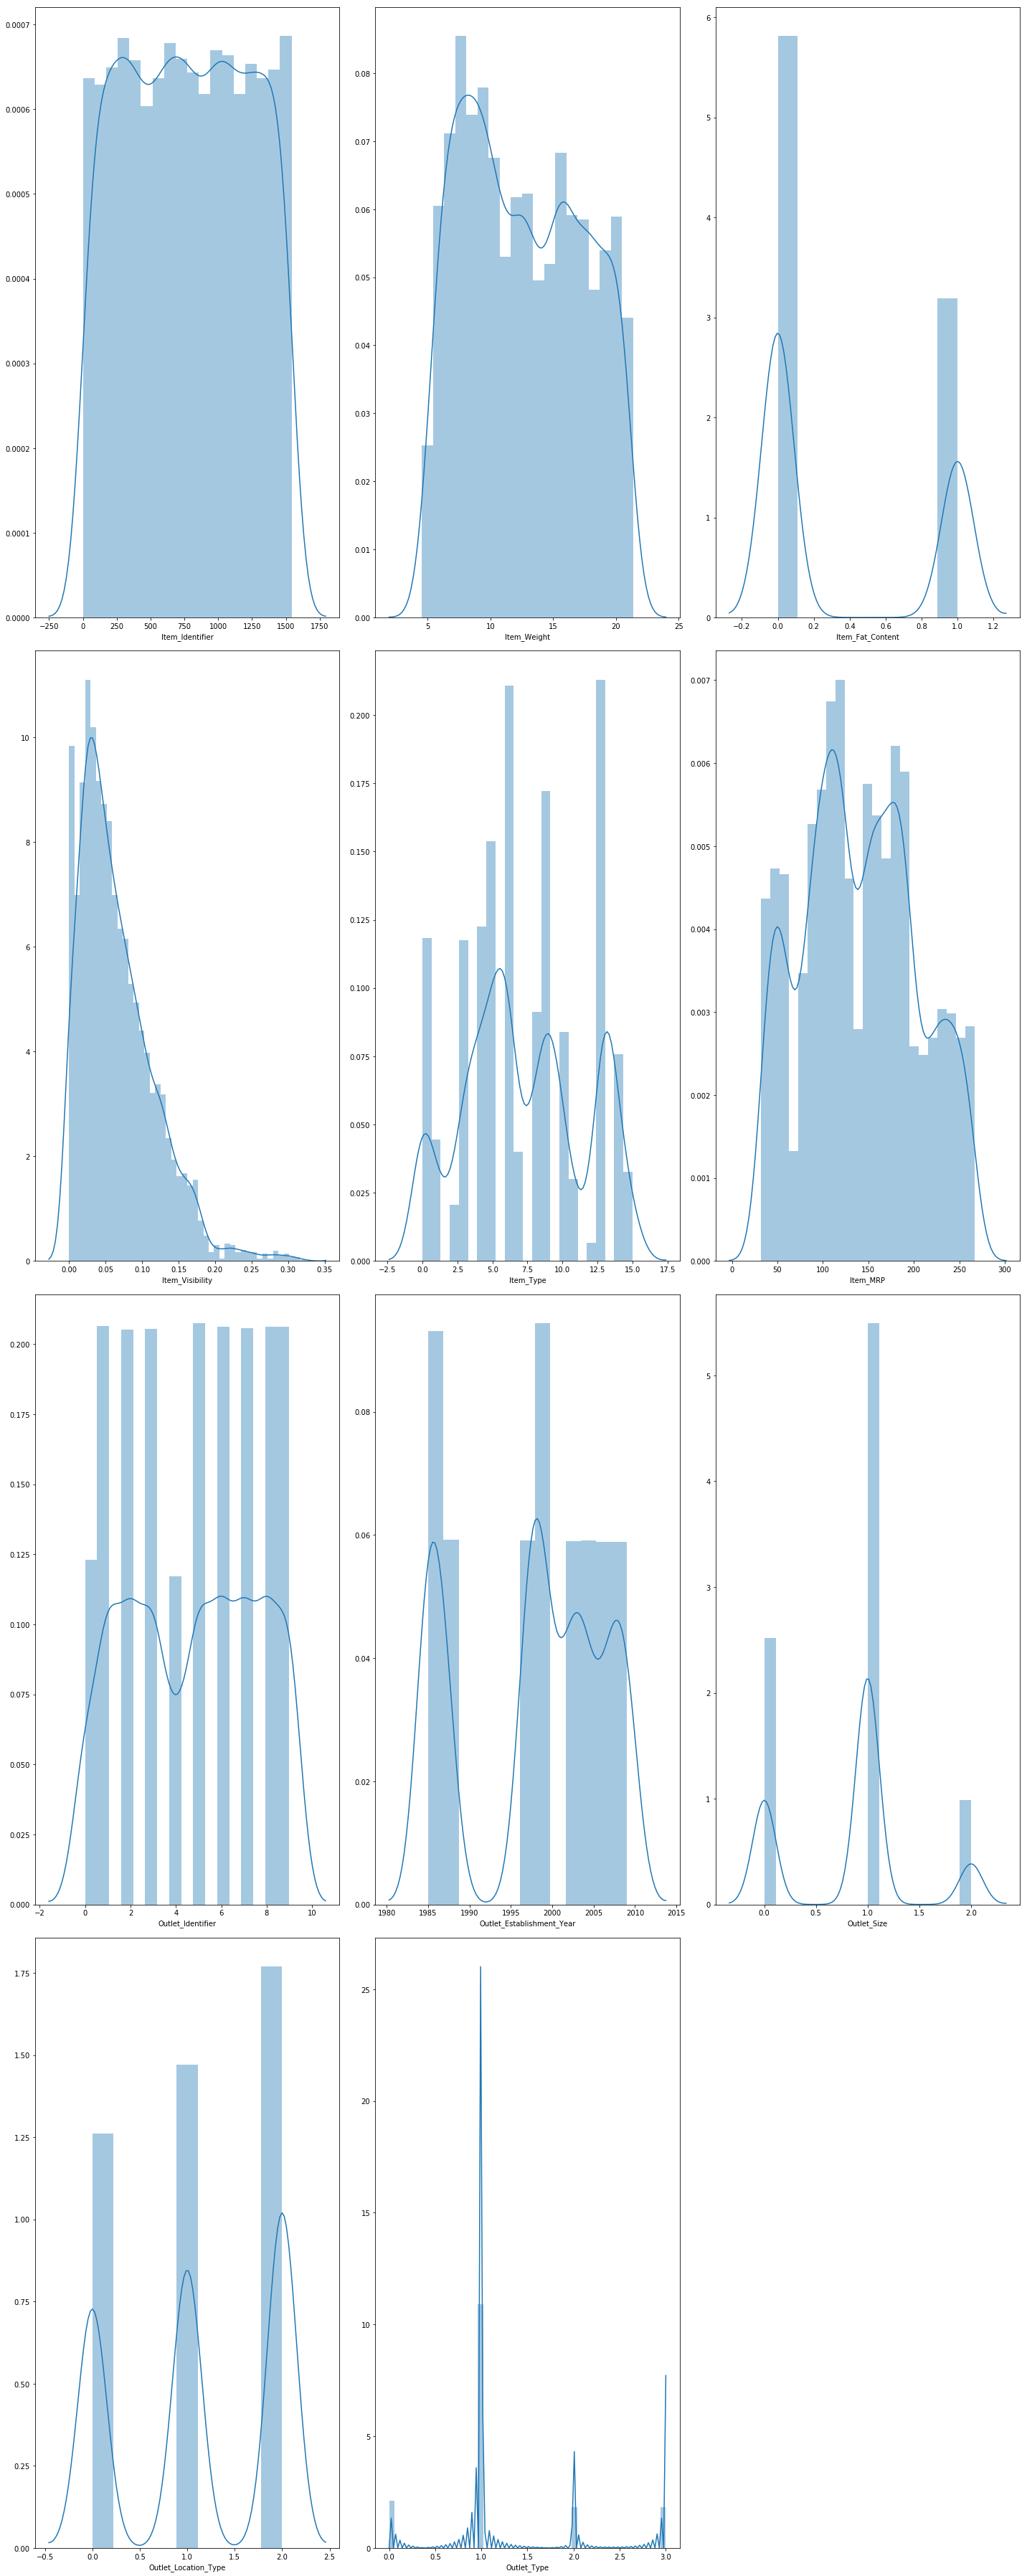

In [309]:
plt.figure(figsize=(20,50))
graph=1
for col in data_test:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.distplot(data_test[col])
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

Graph1: It seems to be like that the  unique id of item is normally distributed .

Graph2: It seems to be like that the  weight of item is normally distributed.

Graph3:  It seems to be like that the  fat content  of item is not normally distributed.

Graph4: Its seems like the visibility skewed.

Graph5: the type of items are equally distributed

Graph6: It seems to be like that the  MRP of item is normally distributed.

Graph7: It seems to be like that the  ids of outlet are normally distributed..

Graph8: It seems to be like that the establishment of outlet is normally distributed.

Graph9: It seems to be like that the  size of outlet is not normally distributed.

Graph10: It seems to be like that the  location type of outlet is not normally distributed.

Graph 11: It seems to be like that the type of outlet is not normally distributed.

In [310]:
data_test.skew()

Item_Identifier             -0.000020
Item_Weight                  0.144712
Item_Fat_Content             0.609223
Item_Visibility              1.238312
Item_Type                    0.096486
Item_MRP                     0.136182
Outlet_Identifier           -0.060209
Outlet_Establishment_Year   -0.396306
Outlet_Size                  0.087108
Outlet_Location_Type        -0.209049
Outlet_Type                  0.927446
dtype: float64

'Item_Fat_Content','Item_Visibility'& 'Outlet_Type' are not in range of -0.5 to 0.5. So they are skewed columns. while others are in range so, there distibution is normal.

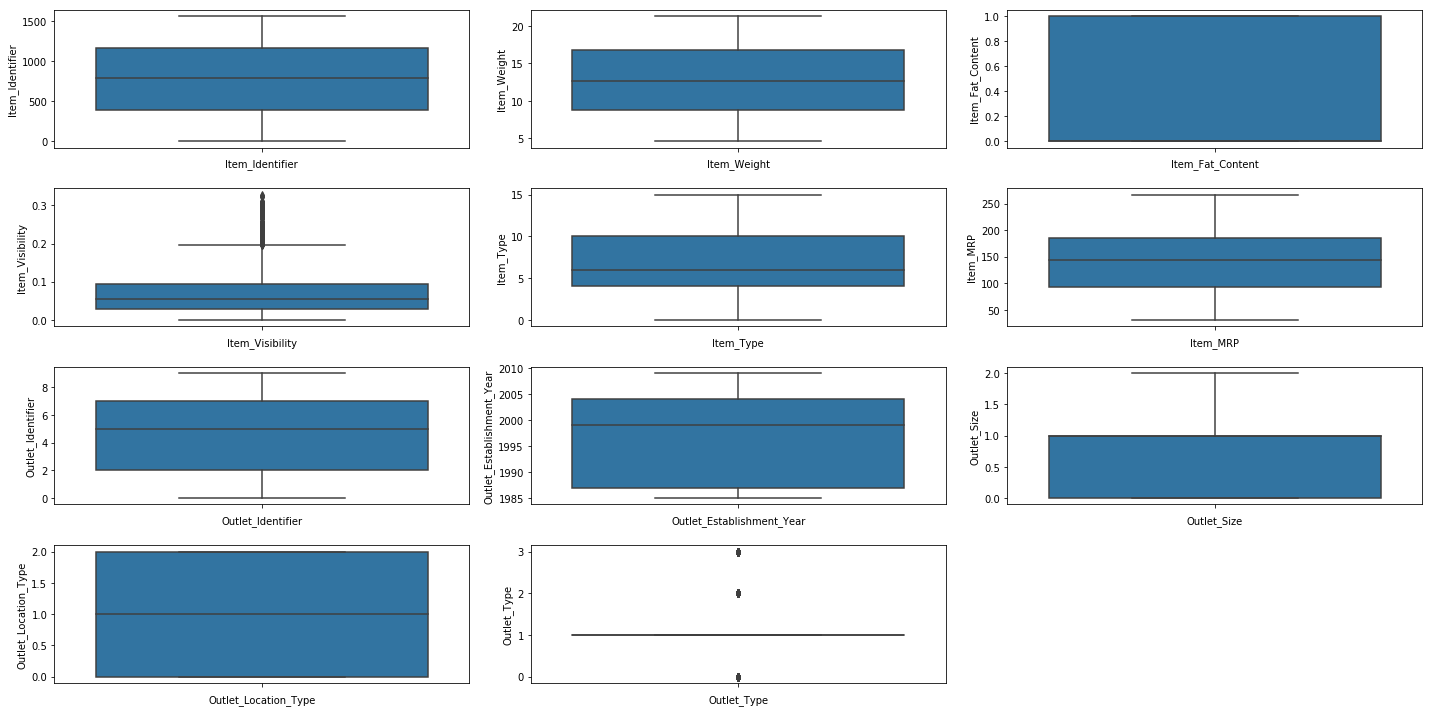

In [311]:
plt.figure(figsize=(20,10))
graph=1
for col in data_train:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.boxplot(data_train[col],orient='v')
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

In Graph 4 the item_visibility & graph 11 type of outlet has outliers while in all other graphs there are no outliers exists.

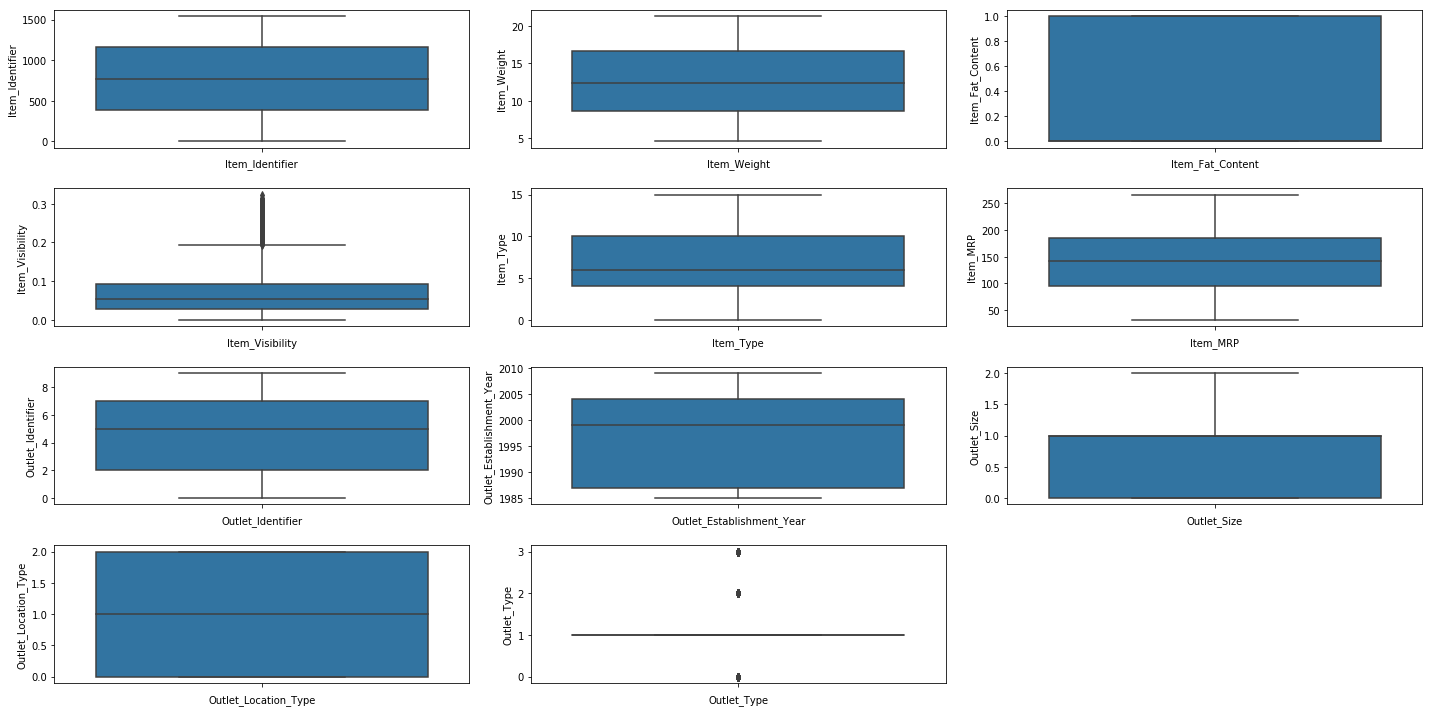

In [312]:
plt.figure(figsize=(20,10))
graph=1
for col in data_test:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.boxplot(data_test[col],orient='v')
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

In Graph 4 the item_visibility & graph 11 type of outlet has outliers while in all other graphs there are no outliers exists.

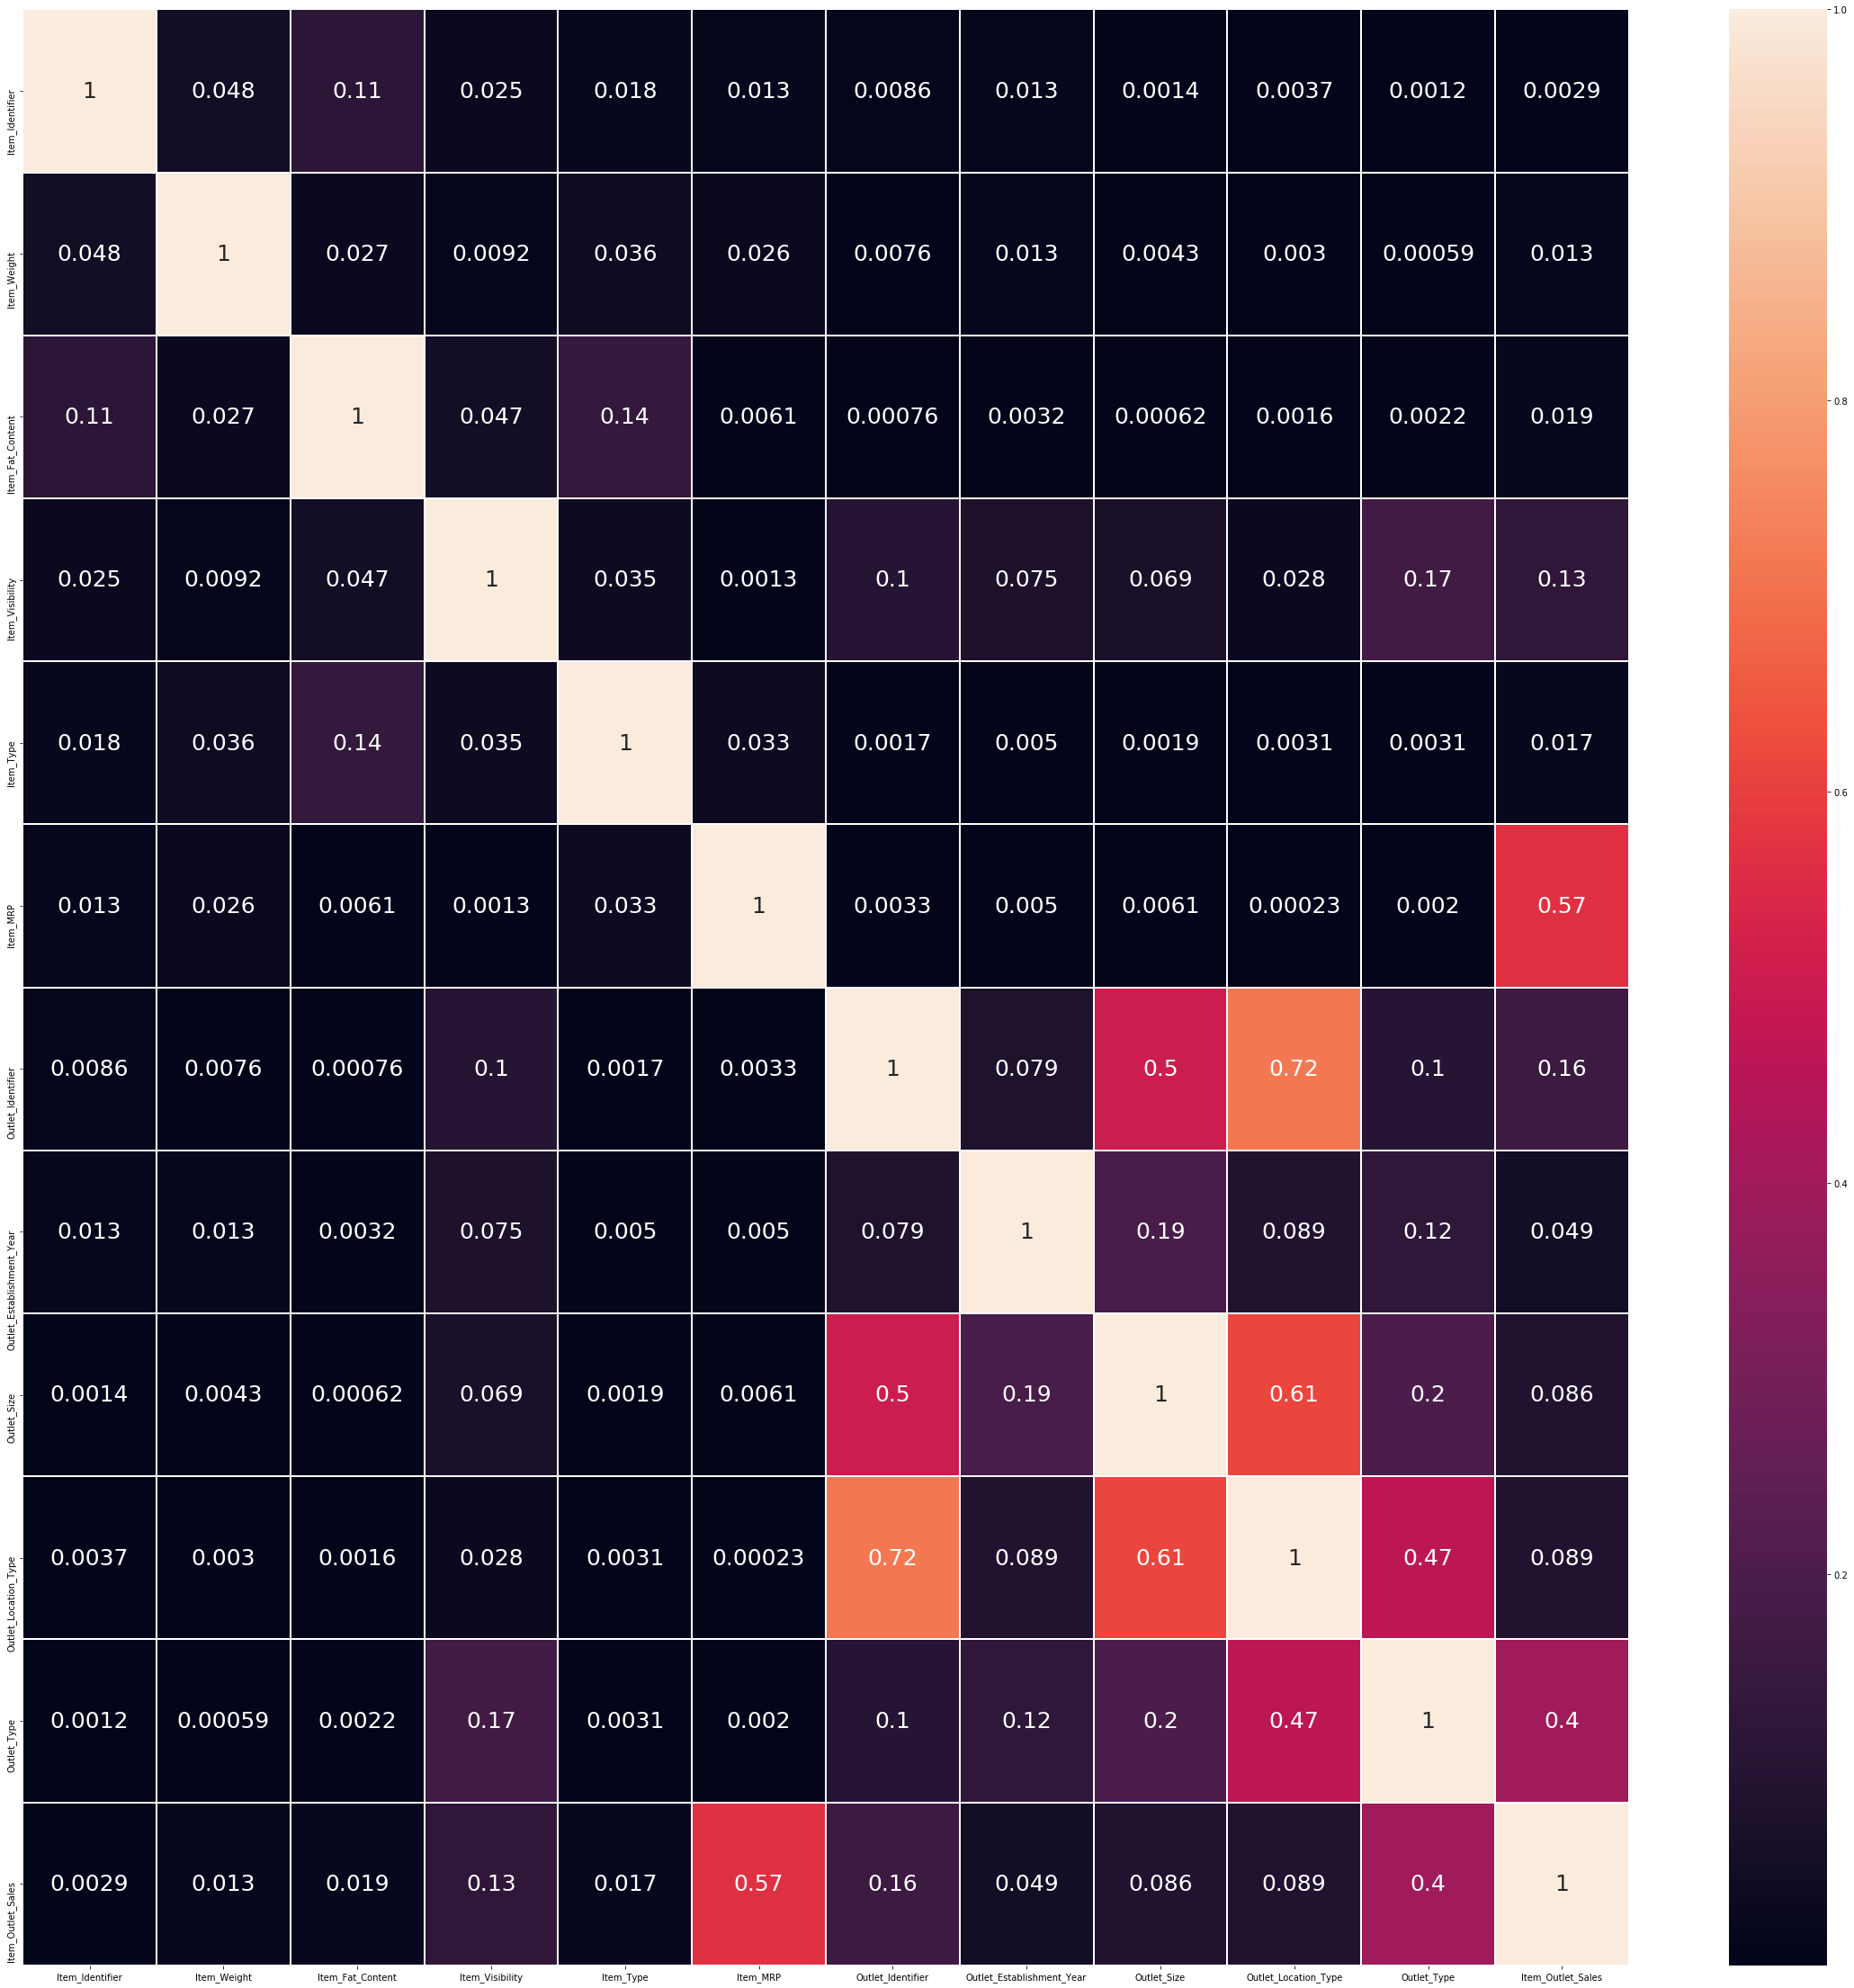

In [313]:
plt.figure(figsize=(40,40))
sns.heatmap(data_train.corr().abs(),annot=True,annot_kws={"size":25},linewidths=True)
plt.show()

1. There 72% of multicolinearity exists between the columns Outlet_Location_type and Outlet_identifier.

2. there 61% of multicolinearity exists between the columns Outlet_Size and Outlet_Location_Type.

3. the Item_Outlet_sale is dependent on  Item_MRP column with 57% helpful, Outlet_Type with 40%, and 13% with item_visibility and 16% outlet_idetifier


In [314]:
data_train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

## Hypothesis testing & p_value

Ho: No relationship exists between target variable(i.e. Outlet_sales) & features . 

H1: reltionship exists between target variable(i.e. Outlet_sales) & features. 

In [315]:
lm=smf.ols(formula='Item_Outlet_Sales~Item_Identifier+Item_Weight+Item_Fat_Content+Item_Visibility+Item_Type+Item_MRP+Outlet_Identifier+Outlet_Establishment_Year+Outlet_Size+Outlet_Location_Type+Outlet_Type',data=data_train).fit()

lm.pvalues

Intercept                     6.126621e-01
Item_Identifier               8.116726e-01
Item_Weight                   8.892614e-01
Item_Fat_Content              4.478061e-02
Item_Visibility               7.603491e-08
Item_Type                     7.784065e-01
Item_MRP                      0.000000e+00
Outlet_Identifier             1.309117e-10
Outlet_Establishment_Year     9.187580e-01
Outlet_Size                   5.649921e-33
Outlet_Location_Type          8.372303e-09
Outlet_Type                  9.878056e-229
dtype: float64

Here we getting the pValues of each column:

    So, from above information we can conclude that the column that are greater than 0.05 are ready to accepts the null hypothesis.
    
    The columns that are Item_Identifier,Item_Weight,Item_Type,Outlet_Establishment_Year  are the columns thats pvalues are greater than 0.05 which means these columns are ready to accepts the null hypothesis.
    
    While other columns rejects to accepts the null hypothesis as their pvalues is smaller than 0.05.

In [316]:
data_train.shape

(8523, 12)

there are 8523 no. of records before cleaning.

## DATA Cleaning

In [317]:
data_trainin.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,779.714889,12.875418,0.352693,0.066132,7.226681,140.992782,4.722281,1997.831867,0.829168,1.112871,1.201220,2181.288914
std,449.222377,4.645016,0.477836,0.051598,4.209990,62.275067,2.837201,8.371760,0.600327,0.812757,0.796459,1706.499616
min,0.000000,4.555000,0.000000,0.000000,0.000000,31.290000,0.000000,1985.000000,0.000000,0.000000,0.000000,33.290000
25%,395.500000,8.785000,0.000000,0.026989,4.000000,93.826500,2.000000,1987.000000,0.000000,0.000000,1.000000,834.247400
50%,783.000000,12.650000,0.000000,0.053931,6.000000,143.012800,5.000000,1999.000000,1.000000,1.000000,1.000000,1794.331000
75%,1167.000000,16.850000,1.000000,0.094585,10.000000,185.643700,7.000000,2004.000000,1.000000,2.000000,1.000000,3101.296400
max,1558.000000,21.350000,1.000000,0.328391,15.000000,266.888400,9.000000,2009.000000,2.000000,2.000000,3.000000,13086.964800


IN the column Item_fat_content has standard deviation greter then its mean value. this applies that the column is not normaly distributed. and in column Outlet_Type 2 type of outet are not such distributed in that column.

In [318]:
data_test.describe()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000,5681.000000
mean,773.386376,12.676136,0.354339,0.065684,7.233410,141.023273,4.722760,1997.828903,0.829079,1.112832,1.201373
std,445.525926,4.649378,0.478355,0.051252,4.219057,61.809091,2.837201,8.372256,0.600328,0.812824,0.796740
min,0.000000,4.555000,0.000000,0.000000,0.000000,31.990000,0.000000,1985.000000,0.000000,0.000000,0.000000
25%,382.000000,8.630000,0.000000,0.027047,4.000000,94.412000,2.000000,1987.000000,0.000000,0.000000,1.000000
50%,771.000000,12.350000,0.000000,0.054154,6.000000,141.415400,5.000000,1999.000000,1.000000,1.000000,1.000000
75%,1160.000000,16.700000,1.000000,0.093463,10.000000,186.026600,7.000000,2004.000000,1.000000,2.000000,1.000000
max,1542.000000,21.350000,1.000000,0.323637,15.000000,266.588400,9.000000,2009.000000,2.000000,2.000000,3.000000


IN the column Item_fat_content has standard deviation greter then its mean value. this applies that the column is not normaly distributed. and in column Outlet_Type 2 type of outet are not such distributed in that column.

REmoving Duplicates.

In [319]:
data_train.drop_duplicates(inplace=True)

In [320]:
data_test.drop_duplicates(inplace=True)

In [321]:
data_train.shape

(8523, 12)

In [322]:
data_test.shape

(5681, 11)

NO, duplicates in training & test daataset.

###### Removing outliers

In [323]:

zs=zscore(data_train[["Item_Visibility","Outlet_Type"]])
filtered=(np.abs(zs)<3).all(axis=1)
data_train=data_train[filtered]

Removed outliers for the type of outlet and visibility of item from training dataset..

In [324]:
zs=zscore(data_test[["Item_Visibility","Outlet_Type"]])
filtered=(np.abs(zs)<3).all(axis=1)
data_test=data_test[filtered]

Removed outliers for the type of outlet and visibility of item from test dataset

In [325]:
data_train.shape

(8428, 12)

In [326]:
data_test.shape

(5600, 11)

## Checking for outliers using boxplot for both training &test dataset

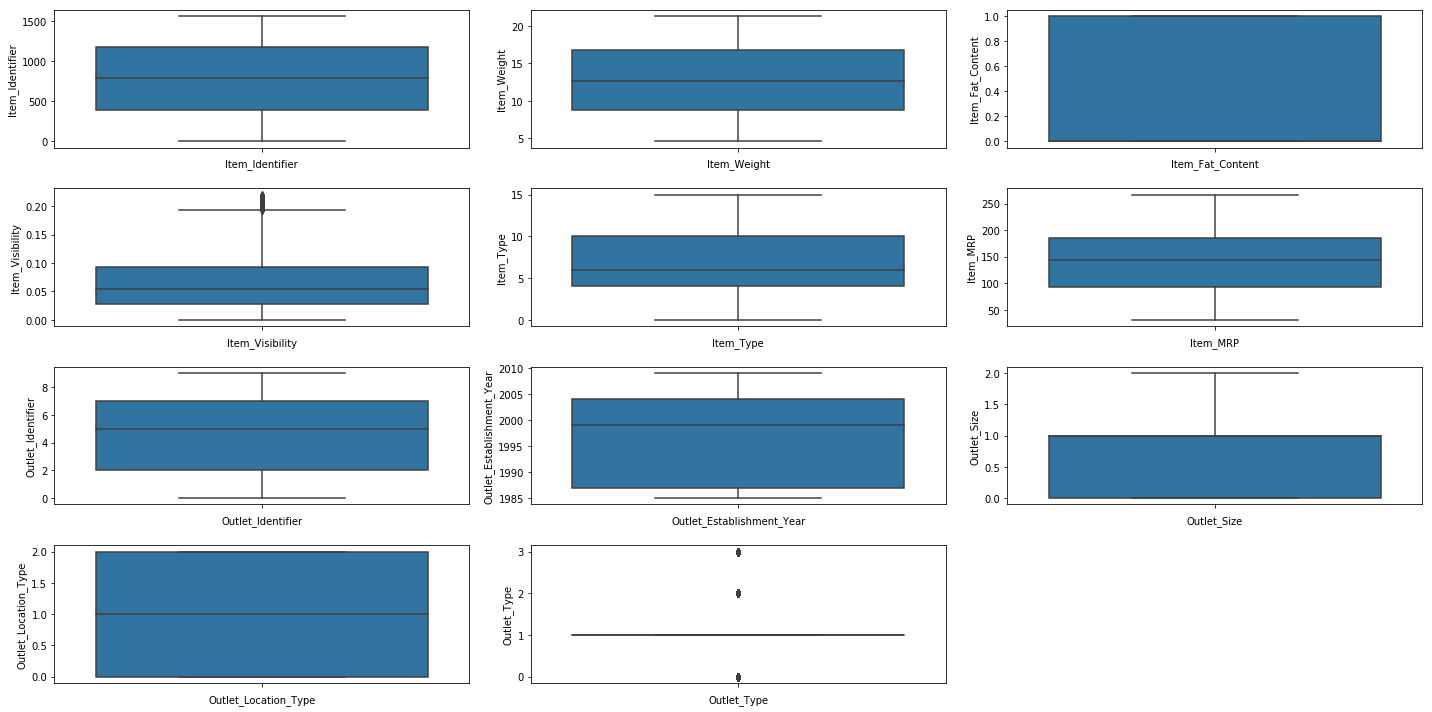

In [327]:
plt.figure(figsize=(20,10))
graph=1
for col in data_test:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.boxplot(data_train[col],orient='v')
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

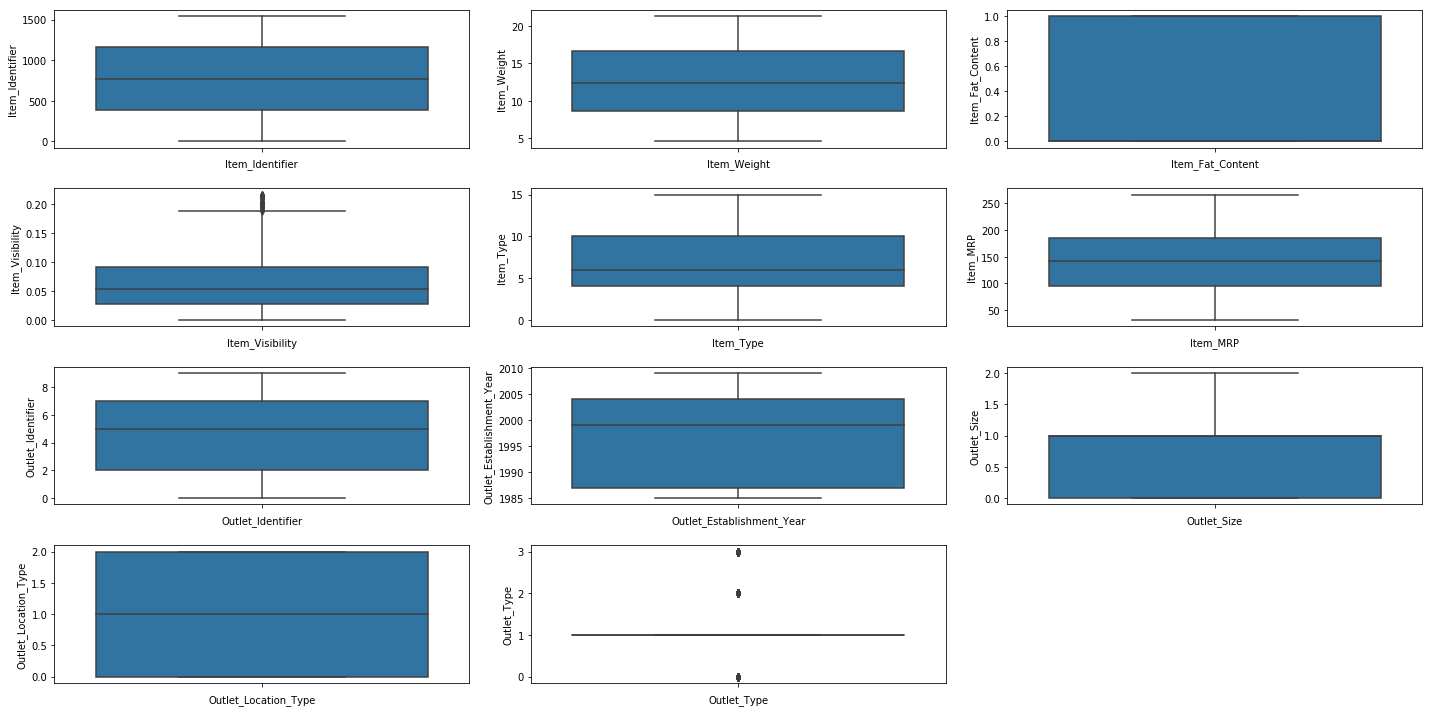

In [328]:
plt.figure(figsize=(20,10))
graph=1
for col in data_test:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.boxplot(data_test[col],orient='v')
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

## Normailizing the distribution

In [329]:
features=data_train.columns.tolist()
f=features[:-1]

In [330]:
scalar=PowerTransformer(method='yeo-johnson')
data_train[f]=scalar.fit_transform(data_train[f].values)
data_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,-1.460187,-0.734583,-0.736710,-1.142270,-0.713260,1.622782,1.423152,0.039060,0.308401,-1.380097,-0.145161,3735.1380
1,-2.093558,-1.598850,1.357386,-1.032913,1.505750,-1.595589,-0.561913,1.453989,0.308401,1.089709,1.034704,443.4228
2,-0.153960,0.990250,-0.736710,-1.117874,0.684503,0.081596,1.423152,0.039060,0.308401,-1.380097,-0.145161,2097.2700
3,0.772354,1.306840,1.357386,-1.734798,-0.216081,0.690021,-1.820107,-0.085435,0.308401,1.089709,-1.974400,732.3800
4,1.096612,-0.823160,-0.736710,-1.734798,0.468305,-1.476469,-1.356875,-1.281792,1.856328,1.089709,-0.145161,994.7052
5,0.052029,-0.479396,1.357386,-1.734798,-1.924399,-1.528400,-0.561913,1.453989,0.308401,1.089709,1.034704,556.6088
6,-0.080085,0.228162,1.357386,-1.257479,1.306137,-1.397702,-1.356875,-1.281792,1.856328,1.089709,-0.145161,343.5528
7,0.009762,1.270145,-0.736710,1.316607,1.306137,-0.469449,0.145851,-1.468606,0.308401,1.089709,1.925200,4022.7636
8,-0.667320,0.740478,1.357386,-1.120364,-0.459525,-0.655714,0.802337,0.430122,0.308401,-0.137247,-0.145161,1076.5986
9,0.521452,1.306840,1.357386,0.809453,-0.459525,0.772584,-0.944454,1.144575,0.308401,-0.137247,-0.145161,4710.5350


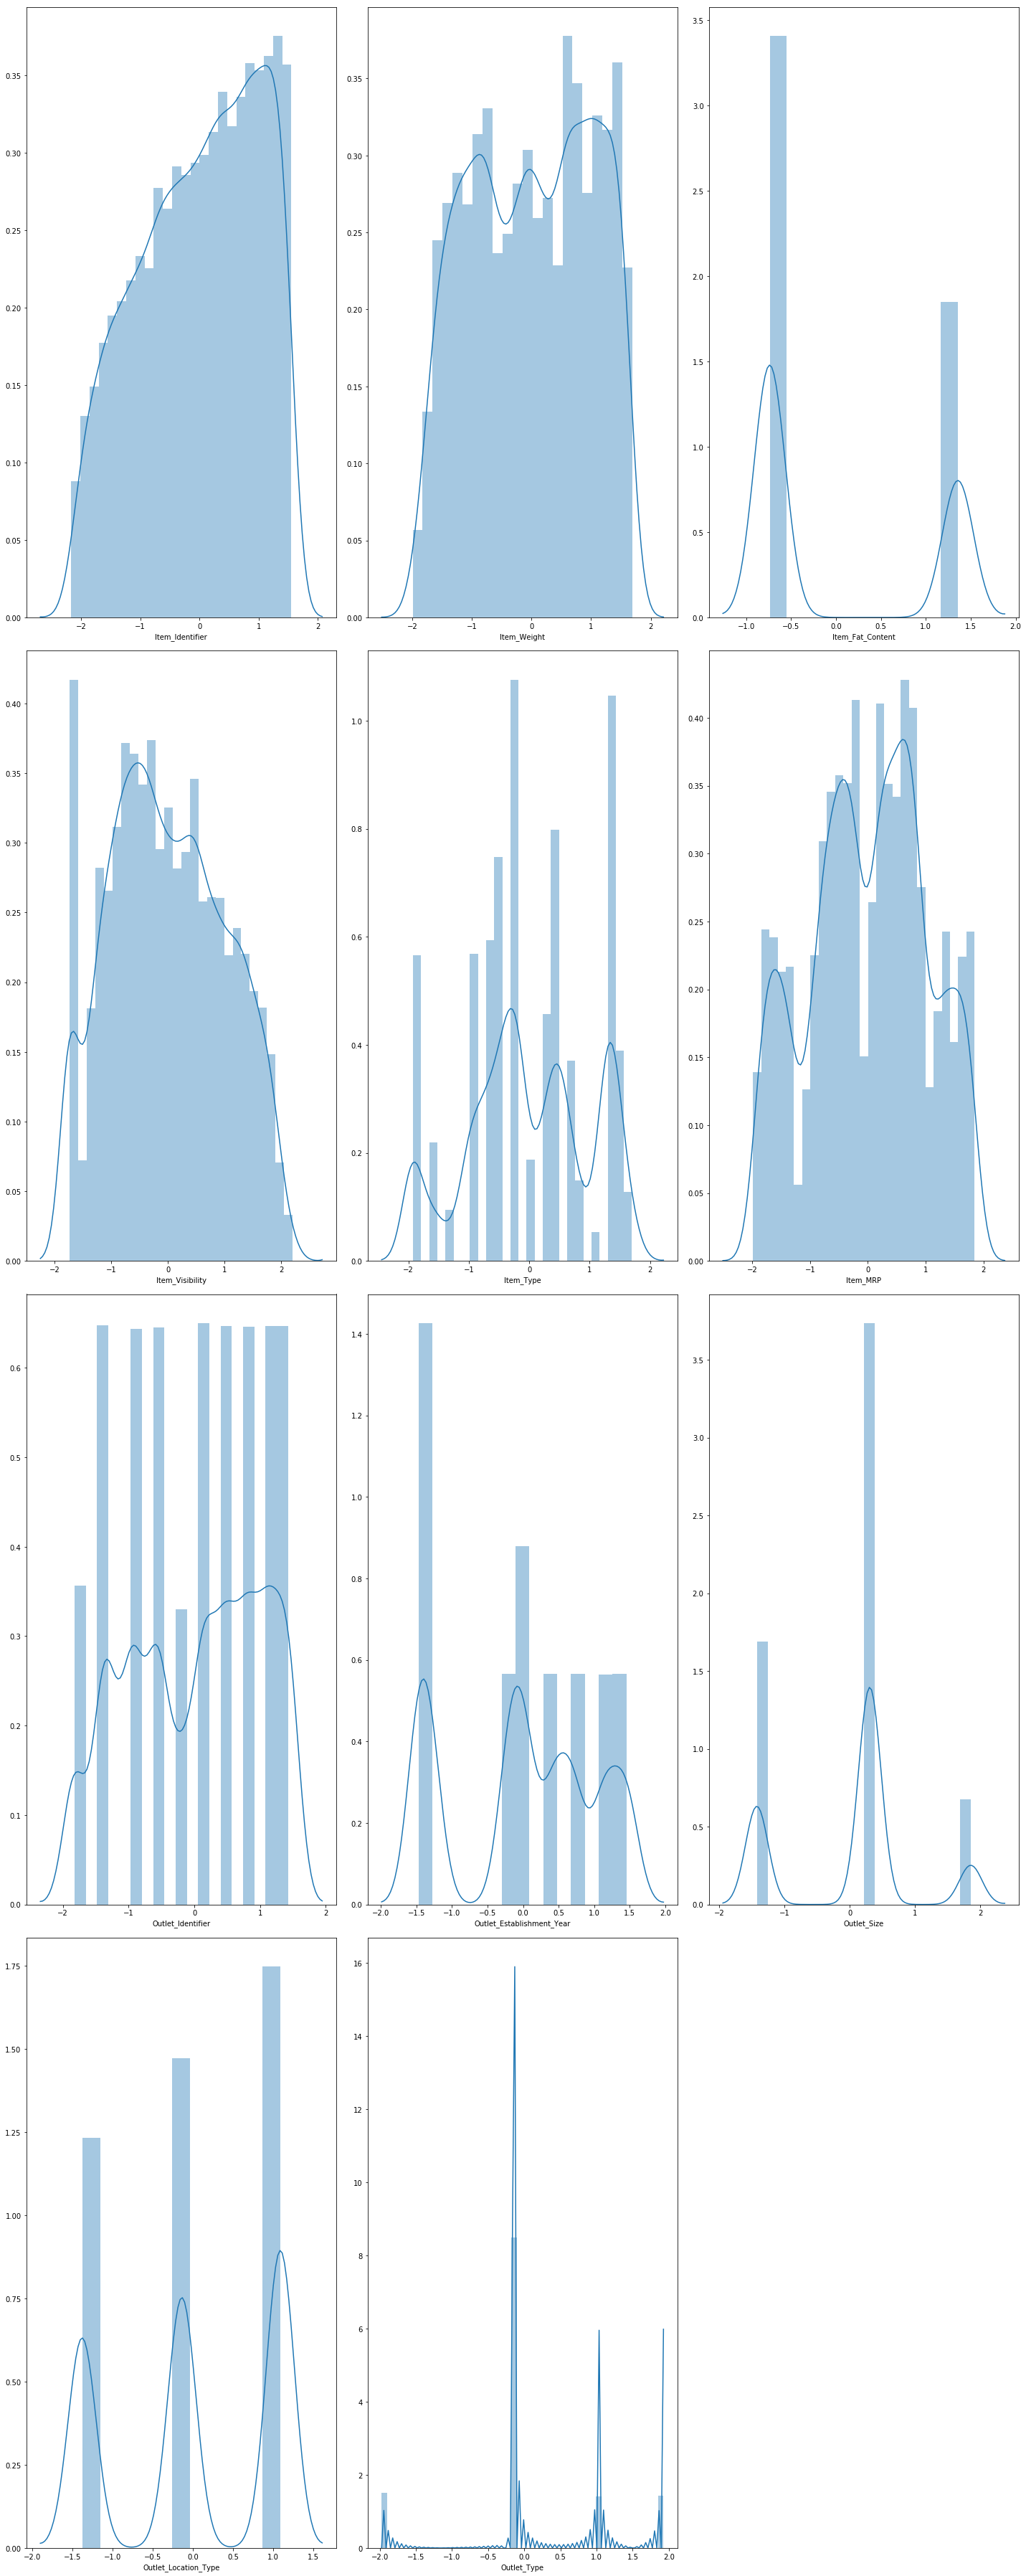

In [331]:
plt.figure(figsize=(20,50))
graph=1
for col in data_train:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.distplot(data_train[col])
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

As we do Power Transformer technique so that we normal distribution.

In [332]:
data_train.skew()

Item_Identifier             -0.293573
Item_Weight                 -0.089666
Item_Fat_Content             0.620786
Item_Visibility              0.115444
Item_Type                   -0.164518
Item_MRP                    -0.114976
Outlet_Identifier           -0.214763
Outlet_Establishment_Year   -0.213023
Outlet_Size                 -0.072301
Outlet_Location_Type        -0.221268
Outlet_Type                  0.009297
Item_Outlet_Sales            1.173070
dtype: float64

Now, all features are distribued normaslly.

##### Same techniques we apply for test dataset.

In [333]:
scalar=PowerTransformer(method='yeo-johnson')
data_test[f]=scalar.fit_transform(data_test.values)
data_test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.755237,1.588963,-0.738413,-1.453107,1.299513,-0.474785,1.422378,0.037205,0.307006,-1.380965,-0.151382
1,0.686438,-0.927622,1.354256,-0.440632,-0.713854,-0.838728,-0.949875,1.142704,0.307006,-0.137311,-0.151382
2,1.310999,0.478888,-0.738413,0.926222,0.889786,1.525696,-1.824752,-0.087281,0.307006,1.090644,-1.991879
3,0.171593,-1.188068,-0.738413,-1.170062,1.299513,0.288663,-0.949875,1.142704,0.307006,-0.137311,-0.151382
4,0.907712,0.278319,1.354256,1.229130,-0.713854,1.424586,0.141725,-1.470222,0.307006,1.090644,1.925057
5,-0.608502,-0.556805,1.354256,0.212540,-0.219089,-0.317409,1.114843,-0.208944,-1.423594,-1.380965,-0.151382
6,-0.272458,1.352096,1.354256,0.613574,-1.914546,-1.576317,-0.567093,1.452134,0.307006,1.090644,1.032759
7,-1.121890,-0.702978,-0.738413,-1.156314,-1.914546,-0.954731,0.141725,-1.470222,0.307006,1.090644,1.925057
8,-0.129718,-1.472120,1.354256,1.298060,1.299513,-0.686602,0.799736,0.428247,0.307006,-0.137311,-0.151382
9,-1.414323,-1.566268,-0.738413,-1.523570,-1.914546,0.763265,-0.949875,1.142704,0.307006,-0.137311,-0.151382


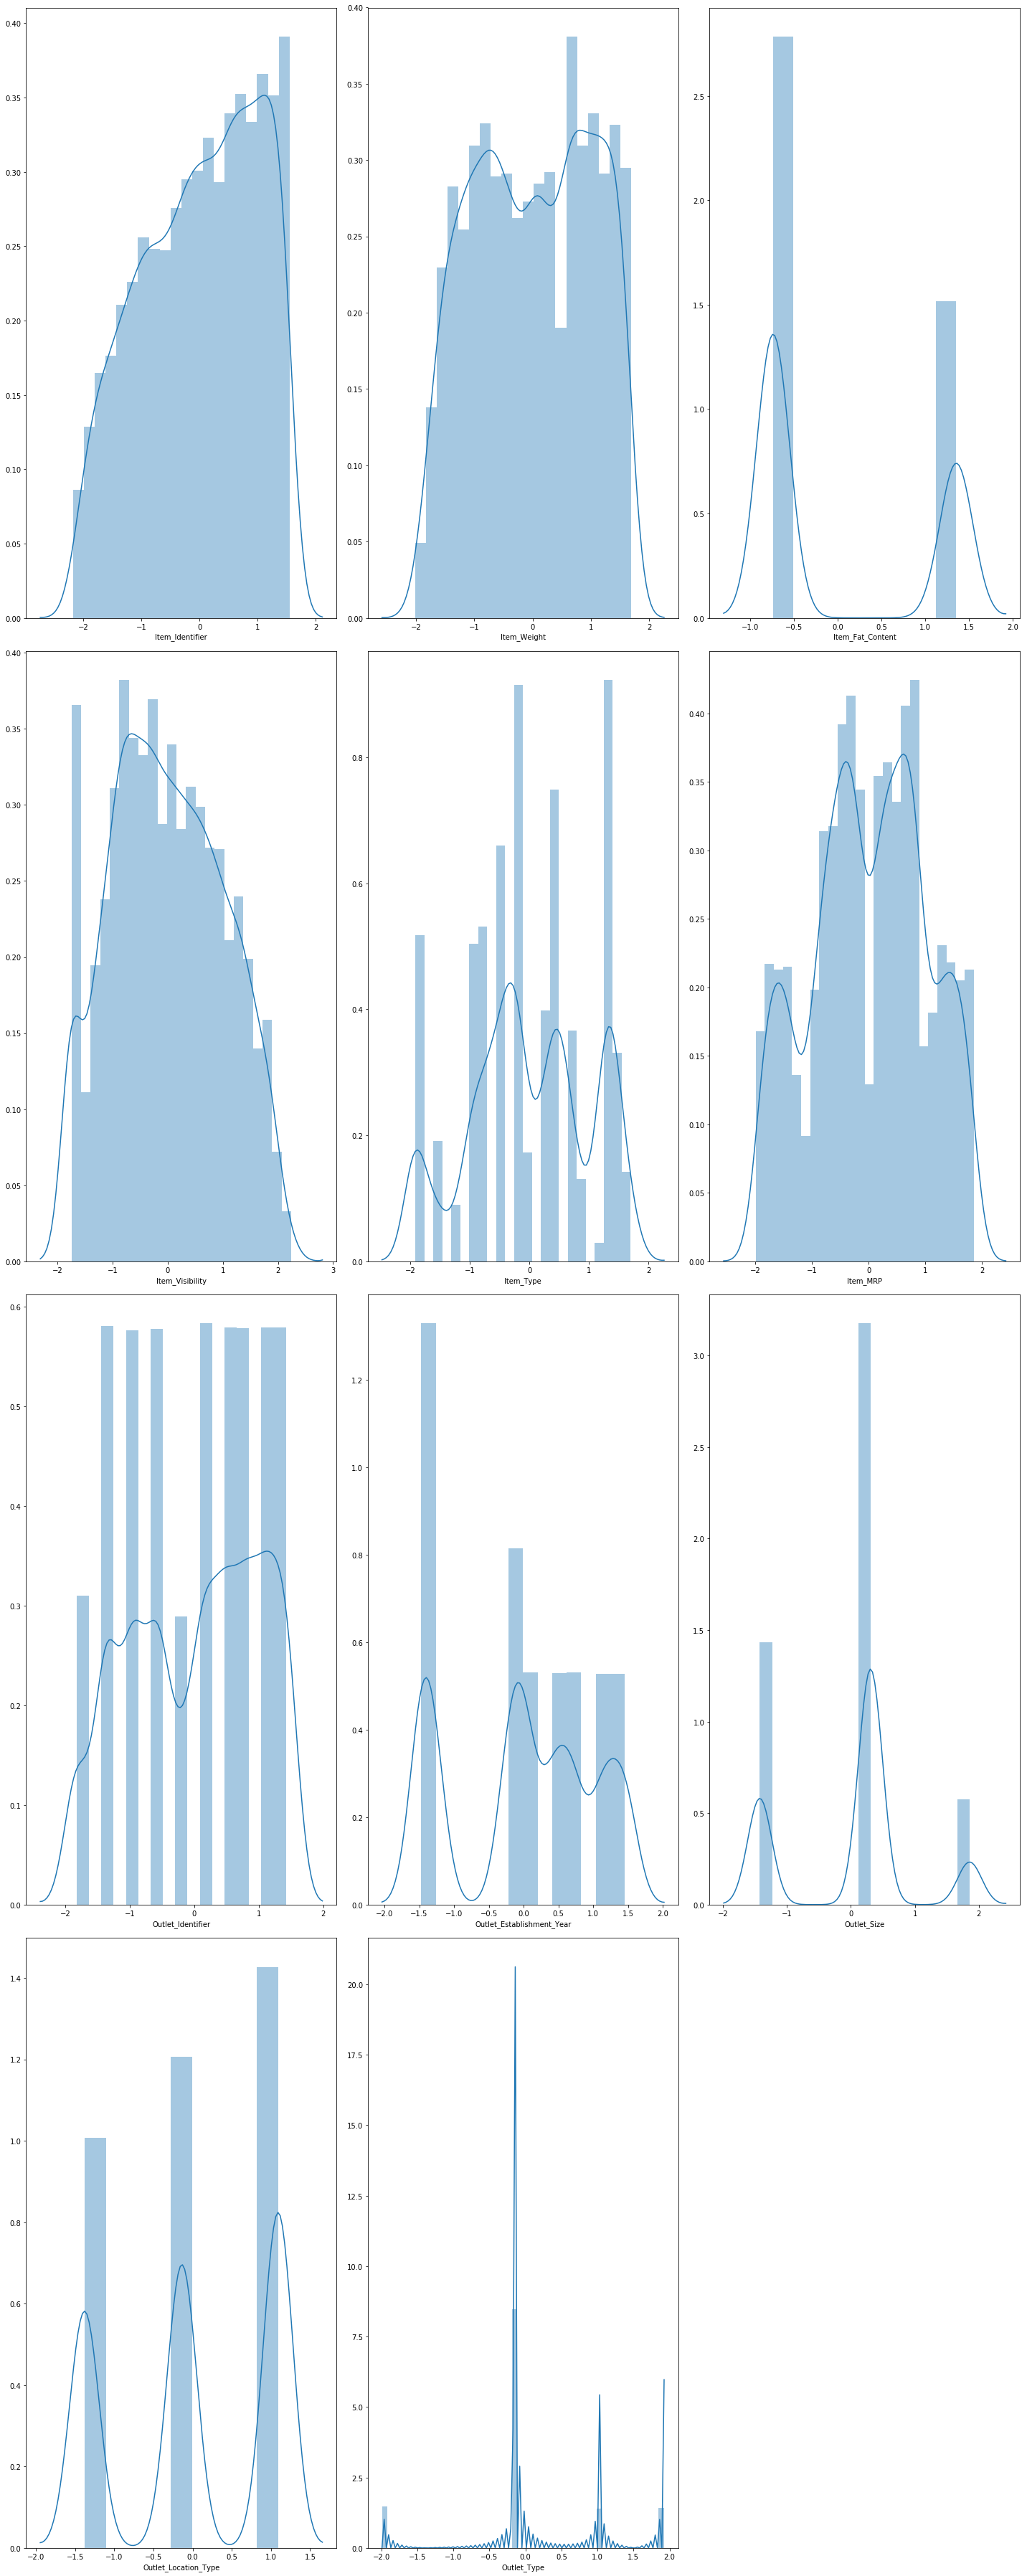

In [334]:
plt.figure(figsize=(20,50))
graph=1
for col in data_test:
    if graph<12:
        ax=plt.subplot(4,3,graph)
        sns.distplot(data_test[col])
        plt.xlabel(col)
    graph+=1
plt.tight_layout()
    

As we do Power Transformer technique so that we normal distribution.

In [335]:
data_test.skew()

Item_Identifier             -0.287266
Item_Weight                 -0.070861
Item_Fat_Content             0.616007
Item_Visibility              0.105676
Item_Type                   -0.169452
Item_MRP                    -0.111505
Outlet_Identifier           -0.214813
Outlet_Establishment_Year   -0.215341
Outlet_Size                 -0.072193
Outlet_Location_Type        -0.220882
Outlet_Type                  0.009585
dtype: float64

Now, all features are distribued normaslly.

In [336]:
data_test.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.755237,1.588963,-0.738413,-1.453107,1.299513,-0.474785,1.422378,0.037205,0.307006,-1.380965,-0.151382
1,0.686438,-0.927622,1.354256,-0.440632,-0.713854,-0.838728,-0.949875,1.142704,0.307006,-0.137311,-0.151382


### Removing column which accepts null hypothesis.

In [337]:
X=data_train.drop(columns='Item_Outlet_Sales')
Y=data_train['Item_Outlet_Sales']

splitting data into fetures & labels.

Here X is our features & Y is our label.

In [338]:
X.corrwith(Y)

Item_Identifier              0.004754
Item_Weight                  0.012154
Item_Fat_Content             0.021202
Item_Visibility             -0.076931
Item_Type                    0.019329
Item_MRP                     0.572278
Outlet_Identifier            0.163777
Outlet_Establishment_Year   -0.053740
Outlet_Size                  0.081393
Outlet_Location_Type         0.087694
Outlet_Type                  0.419608
dtype: float64

the column that has less impact on prediction of sales that are Item_Identifier,Item_Weight,Item_Fat_Content,Item_Type

In [339]:
X.drop(columns=['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Type'],inplace=True,axis=1)

In [340]:
X.shape

(8428, 7)

dropped columns now the shape has changed.

In [341]:
data_test.drop(columns=['Item_Identifier','Item_Weight','Item_Fat_Content','Item_Type'],inplace=True,axis=1)

In [342]:
data_test.shape

(5600, 7)

as these features also should be dropped because these has no such impact to the label. 

In [343]:
scalar=StandardScaler()
X_scaled=scalar.fit_transform(X)

In [344]:
scalar=StandardScaler()
Xtt_scaled=scalar.fit_transform(data_test)

Standarized the features .

In [345]:
vif=pd.DataFrame()
vif['vif']=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif['Features']=X.columns

In [346]:
vif

,vif,Features
0,1.022728,Item_Visibility
1,1.000206,Item_MRP
2,4.703737,Outlet_Identifier
3,1.042913,Outlet_Establishment_Year
4,1.712762,Outlet_Size
5,5.469949,Outlet_Location_Type
6,2.768149,Outlet_Type


From above information we get to know that the column Outlet_Location_type has valu 5.47 i.e. greater than 5. So, we can drop this value becoz this it multi-colinearity problem.

In [347]:
X.drop('Outlet_Location_Type',axis=1,inplace=True)

In [348]:
X.shape

(8428, 6)

###### Same  we do to test data

In [349]:
vif=pd.DataFrame()
vif['vif']=[variance_inflation_factor(Xtt_scaled,i) for i in range(Xtt_scaled.shape[1])]
vif['Features']=data_test.columns
vif

,vif,Features
0,1.019731,Item_Visibility
1,1.000397,Item_MRP
2,4.685115,Outlet_Identifier
3,1.046481,Outlet_Establishment_Year
4,1.713040,Outlet_Size
5,5.476445,Outlet_Location_Type
6,2.751811,Outlet_Type


From above information we get to know that the column Outlet_Location_type has valu 5.47 i.e. greater than 5. So, we can drop this value becoz this it multi-colinearity problem.

In [350]:
data_test.drop('Outlet_Location_Type',axis=1,inplace=True)

In [351]:
data_test.shape

(5600, 6)

### Data loss

In [352]:
print(f"The Trained Dataset has lost the records in percentage after Cleaning:: {((8523-8428)/8523)*100}%")

The Trained Dataset has lost the records in percentage after Cleaning:: 1.1146309984747156%


In [353]:
print(f"The Test Dataset has lost the records in percentage after Cleaning:: {((5681-5600)/5681)*100}%")

The Test Dataset has lost the records in percentage after Cleaning:: 1.425805315965499%


## Model Deployment

In [354]:
max_accuracy=0
for i in range(1,150):
    X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.2,random_state=i)
    lr=LinearRegression()
    lr.fit(X_train,Y_train)
    Y_pred=lr.predict(X_test)
    accuracy=r2_score(Y_test,Y_pred)*100
    if accuracy>max_accuracy:
        max_accuracy=accuracy
        rs=i
print(f"The highest accuracy is {max_accuracy} at random state {rs}")
    
    

The highest accuracy is 55.881980395947785 at random state 115


In [355]:
X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y,test_size=0.2,random_state=rs)

Here we split the training dataset & test dataset at random state rs i.e. 115 where we get the high accuracy

In [356]:
Linear=LinearRegression()
DecisionTree=DecisionTreeRegressor()
knn=KNeighborsRegressor()
RandomForest=RandomForestRegressor()
AdaBoost=AdaBoostRegressor()
Bagging=BaggingRegressor()

In [357]:
algo=[Linear,DecisionTree,RandomForest,knn,AdaBoost,Bagging]
acc_models={}
for model in algo:
    model.fit(X_train,Y_train)
    Y_pred=model.predict(X_test)
    print("-"*60)
    acc_models[model]=round(r2_score(Y_test,Y_pred)*100,1)
    print(f"The model {model} has:: \n\t Accuracy :: {round(r2_score(Y_test,Y_pred)*100,1)}% \n\t Mean Absolute Error is :: {mean_absolute_error(Y_test,Y_pred)} \n\t Mean Squared Error is :: {mean_squared_error(Y_test,Y_pred)} \n\t Root Mean Squared Error is :: {np.sqrt(mean_squared_error(Y_test,Y_pred))}")
    print("-"*60)
    print("\n")

------------------------------------------------------------
The model LinearRegression() has:: 
	 Accuracy :: 55.9% 
	 Mean Absolute Error is :: 880.2010461331687 
	 Mean Squared Error is :: 1387857.8460361795 
	 Root Mean Squared Error is :: 1178.0737863292686
------------------------------------------------------------


------------------------------------------------------------
The model DecisionTreeRegressor() has:: 
	 Accuracy :: 28.3% 
	 Mean Absolute Error is :: 1037.4052523131672 
	 Mean Squared Error is :: 2254170.7446134733 
	 Root Mean Squared Error is :: 1501.3896045375675
------------------------------------------------------------


------------------------------------------------------------
The model RandomForestRegressor() has:: 
	 Accuracy :: 58.5% 
	 Mean Absolute Error is :: 798.7081767485172 
	 Mean Squared Error is :: 1306360.9284071196 
	 Root Mean Squared Error is :: 1142.9614728446097
------------------------------------------------------------


-----------

In [358]:
acc_models

{LinearRegression(): 55.9,
 DecisionTreeRegressor(): 28.3,
 RandomForestRegressor(): 58.5,
 KNeighborsRegressor(): 56.5,
 AdaBoostRegressor(): 56.3,
 BaggingRegressor(): 55.5}

here we get the maximum r2-score of each model

### Crooss-Vaidation of the model

In [359]:
CVmodel={}

for model in algo:
    CVscore_={}
    print(f"\n{model}")
    print("-"*25)
    print("\n")
    for i in range(2,10):
        cvS=cross_val_score(model,X_scaled,Y,cv=i)
        CVscore_[i]=cvS.mean()
        print(f"Mean CV Score of model {model}:: {cvS.mean()} at k-fold::{i}\n")
    CVdata=pd.DataFrame(CVscore_,index=[""])
    CVmodel[str(model)]=CVdata.max(axis=1).tolist()


LinearRegression()
-------------------------


Mean CV Score of model LinearRegression():: 0.519561335629882 at k-fold::2

Mean CV Score of model LinearRegression():: 0.5190328063714021 at k-fold::3

Mean CV Score of model LinearRegression():: 0.5180793211852659 at k-fold::4

Mean CV Score of model LinearRegression():: 0.5187317026849907 at k-fold::5

Mean CV Score of model LinearRegression():: 0.5189041583628434 at k-fold::6

Mean CV Score of model LinearRegression():: 0.519188252252185 at k-fold::7

Mean CV Score of model LinearRegression():: 0.5186428749935754 at k-fold::8

Mean CV Score of model LinearRegression():: 0.5188069461731378 at k-fold::9


DecisionTreeRegressor()
-------------------------


Mean CV Score of model DecisionTreeRegressor():: 0.19159407395815387 at k-fold::2

Mean CV Score of model DecisionTreeRegressor():: 0.18614858304016327 at k-fold::3

Mean CV Score of model DecisionTreeRegressor():: 0.17542444318174277 at k-fold::4

Mean CV Score of model DecisionTreeR

In [360]:
CVmodel

{'LinearRegression()': [0.519561335629882],
 'DecisionTreeRegressor()': [0.19159407395815387],
 'RandomForestRegressor()': [0.5432696417851923],
 'KNeighborsRegressor()': [0.5294499041483308],
 'AdaBoostRegressor()': [0.5233255942271988],
 'BaggingRegressor()': [0.5162933378947164]}

here we can see the maximun CV score of each model

In [361]:
acc_value=list(acc_models.values ( ))

m=list(CVmodel.keys())

print("The least difference between the r2-score and CV score of each model is::\n")
for i in range(6):
    print(f"{m[i]}::{round(np.abs(CVmodel[m[i]][0]*100-acc_value[i]),2)}")

The least difference between the r2-score and CV score of each model is::

LinearRegression()::3.94
DecisionTreeRegressor()::9.14
RandomForestRegressor()::4.17
KNeighborsRegressor()::3.56
AdaBoostRegressor()::3.97
BaggingRegressor()::3.87


here for model KNeighborsRegressor we get the least value i.e. the difference between the r2-score and cvScore of this model is 3.56. So, knn is the best model to use for this problem.

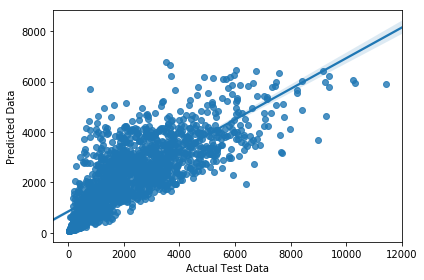

In [362]:
knn.fit(X_train,Y_train)
Y_pred=br.predict(X_test)
sns.regplot(Y_test,Y_pred)
plt.xlabel("Actual Test Data")
plt.ylabel("Predicted Data")
plt.tight_layout()

Here we analyse that the best fit line is fiited well between the points but are deviated due to which the residual is high..

## Regularization

In [363]:
lasso=Lasso()
parameters={"alpha":np.arange(0.0001,0.1,0.001),'normalize':[True,False],'max_iter':[1000,1500,2000]}
grid=GridSearchCV(lasso,parameters)
grid.fit(X_train,Y_train)
grid.best_params_

{'alpha': 0.0001, 'max_iter': 1000, 'normalize': False}

Here we get the best paameter for Lasso. So, that we can see our model is overfitted/underfitted or not.

In [364]:
lasso=Lasso(alpha= 0.0001, max_iter= 1000, normalize=False)
lasso.fit(X_train,Y_train)
pred=lasso.predict(X_test)
r2_score(Y_test,pred)*100

55.881978854594486

Here we can see that our model is not overfitted/ underfitted as the r2 scoe Lasso model i.e. 55.88 is less with KNeighborsRegressor  model r2_score that is 56.5.

## Hyper parameter Tuning

In [374]:
knn=KNeighborsRegressor()

In [404]:
params_grid={
    'algorithm':['kd_tree','brute'],
    'leaf_size':[2,3],
    'n_neighbors':range(30,36),
    'p':[1,2]
    
}

In [405]:
grid=GridSearchCV(estimator=knn,param_grid=params_grid)
grid.fit(X_train,Y_train)

GridSearchCV(estimator=KNeighborsRegressor(algorithm='kd_tree', leaf_size=2,
                                           n_neighbors=45),
             param_grid={'algorithm': ['kd_tree', 'brute'], 'leaf_size': [2, 3],
                         'n_neighbors': range(30, 36), 'p': [1, 2]})

In [406]:
grid.best_estimator_

KNeighborsRegressor(algorithm='kd_tree', leaf_size=2, n_neighbors=35)

In [407]:
knn=grid.best_estimator_   ##reinstantiating the beast parameter to algo
knn.fit(X_train,Y_train)
Y_pred=knn.predict(X_test)

## Model evaluation

In [408]:
print(f"The model KNeighborsRegressor has:: \n\t Accuracy :: {round(r2_score(Y_test,Y_pred)*100,1)}% \n\t Mean Absolute Error is :: {mean_absolute_error(Y_test,Y_pred)} \n\t Mean Squared Error is :: {mean_squared_error(Y_test,Y_pred)} \n\t Root Mean Squared Error is :: {np.sqrt(mean_squared_error(Y_test,Y_pred))}")


The model KNeighborsRegressor has:: 
	 Accuracy :: 62.2% 
	 Mean Absolute Error is :: 769.1534055753262 
	 Mean Squared Error is :: 1190089.8729221858 
	 Root Mean Squared Error is :: 1090.9124038721834


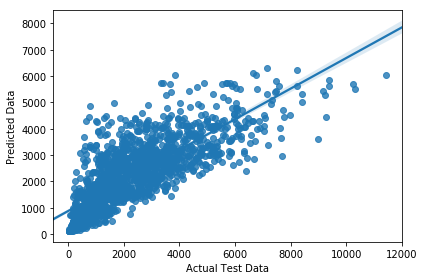

In [409]:
sns.regplot(Y_test,Y_pred)
plt.xlabel("Actual Test Data")
plt.ylabel("Predicted Data")
plt.tight_layout()

Here we can see that the points are now much closer than the earlier KNeighborsRegresso model with default parameter to the best fit line, Its due to decrease in mean absolute error, mean Squared Error,& Root mean squared error. 

And incrsed in the Accuracy

## Saving model

In [410]:
import pickle
pickle.dump(br,open('bigmartt_model.obj','wb'))

In [411]:
loaded_model=pickle.load(open('bigmartt_model.obj','rb'))

In [412]:
data_test.head()

,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Type
0,-1.453107,-0.474785,1.422378,0.037205,0.307006,-0.151382
1,-0.440632,-0.838728,-0.949875,1.142704,0.307006,-0.151382
2,0.926222,1.525696,-1.824752,-0.087281,0.307006,-1.991879
3,-1.170062,0.288663,-0.949875,1.142704,0.307006,-0.151382
4,1.229130,1.424586,0.141725,-1.470222,0.307006,1.925057


In [419]:
data_test_predicted=knn.predict(Xtt_scaled)

In [420]:
data_test_predicted

array([1874.24602286, 1496.96569714,  641.54585714, ..., 1685.91973714,
       4009.65685143, 1234.77365714])

These are the predicted values for the Bigmart test dataset.